# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from scipy.stats import itemfreq, chisquare
from sklearn.preprocessing import OneHotEncoder

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter= ';')
azdias_for_later = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter= ';')
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter= ';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias)
print(feat_info[:10])


        AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0             -1                     2          1            2.0   
1             -1                     1          2            5.0   
2             -1                     3          2            3.0   
3              2                     4          2            2.0   
4             -1                     3          1            5.0   
5              3                     1          2            2.0   
6             -1                     2          2            5.0   
7             -1                     1          1            3.0   
8             -1                     3          1            3.0   
9             -1                     3          2            4.0   
10             0                     3          2            1.0   
11            -1                     2          1            6.0   
12            -1                     3          1            6.0   
13            -1                     1          

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
print(azdias.describe())

            AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min    

In [8]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [9]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values
azdias_nullvalues = azdias.isnull().sum().sum()
print("null values is=" + str(azdias_nullvalues))
info_nullvalues = feat_info.isnull().sum().sum()
print("null values is=" + str(info_nullvalues))

azdias_nullvalues_total = azdias.isnull().sum()
print(azdias_nullvalues_total)



null values is=4896838
null values is=0
AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0


In [11]:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [12]:
feat_info[feat_info.missing_or_unknown == '[-1,XX]']

,attribute,information_level,type,missing_or_unknown
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [13]:
feat_info[feat_info.missing_or_unknown == '[XX]']

,attribute,information_level,type,missing_or_unknown
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]


In [14]:

def is_int(value):
  try:
    int(value)
    return True
  except ValueError:
    return False

data_dict = {'nan_vals': feat_info['missing_or_unknown'].str.replace('[','').str.replace(']','').str.split(',').values}

missing_vals = pd.DataFrame(data_dict, index = feat_info['attribute'].values)

missing_vals['nan_vals'] = missing_vals.apply(lambda x: [int(i) if is_int(i) == True else i for i in x[0]], axis=1)

In [15]:
# turn missing_or_unknown to list 
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

# Identify missing or unknown data values and convert them to NaNs.
for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan


In [16]:
missing_vals['nan_vals'][57]

[-1, 'X']

In [17]:
missing_vals[50:60]

,nan_vals
ANZ_HAUSHALTE_AKTIV,[0]
ANZ_HH_TITEL,[]
GEBAEUDETYP,"[-1, 0]"
KONSUMNAEHE,[]
MIN_GEBAEUDEJAHR,[0]
OST_WEST_KZ,[-1]
WOHNLAGE,[-1]
CAMEO_DEUG_2015,"[-1, X]"
CAMEO_DEU_2015,[XX]
CAMEO_INTL_2015,"[-1, XX]"


In [18]:
for column in azdias.columns:
    # Get index 0 of missing_vals.loc[column] to get actual array
    azdias[column] = azdias[column].replace(missing_vals.loc[column][0], np.nan)

In [19]:
azdias['CAMEO_DEUG_2015'][2511] # After mapping NaNs

nan

In [20]:
azdias['CAMEO_DEU_2015'][58]

'6B'

In [21]:
missing_data = pd.Series(azdias.isnull().sum() / len(azdias))
print(missing_data)

AGER_TYP                 0.769554
ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.005446
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GEBURTSJAHR              0.440203
GFK_URLAUBERTYP          0.005446
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.124768
LP_LEBENSPHASE_FEIN      0.109549
LP_LEBENSPHASE_GROB      0.106115
LP_FAMILIE_FEIN          0.087287
LP_FAMILIE_GROB          0.087287
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
RETOURTYP_BK_S           0.005446
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST    

In [22]:
missing_data[missing_data > 0.2].index.tolist()

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [23]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = pd.Series(azdias.isnull().sum() / len(azdias))
print(missing_data)
print(missing_data.describe())

AGER_TYP                 0.769554
ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.005446
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GEBURTSJAHR              0.440203
GFK_URLAUBERTYP          0.005446
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.124768
LP_LEBENSPHASE_FEIN      0.109549
LP_LEBENSPHASE_GROB      0.106115
LP_FAMILIE_FEIN          0.087287
LP_FAMILIE_GROB          0.087287
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
RETOURTYP_BK_S           0.005446
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST    

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([ 0.        ,  0.09975764,  0.19951527,  0.29927291,  0.39903054,
         0.49878818,  0.59854582,  0.69830345,  0.79806109,  0.89781872,
         0.99757636]),
 <a list of 10 Patch objects>)

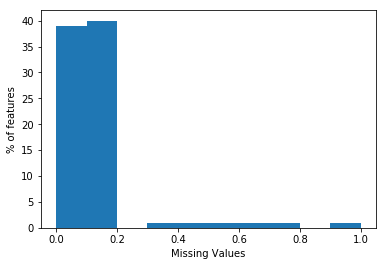

In [24]:
# Investigate patterns in the amount of missing data in each column.
np.histogram(azdias_nullvalues_total.all(), bins='auto' )
plt.xlabel('Missing Values')
plt.ylabel('% of features')
plt.hist(missing_data)



In [25]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
missing_data[missing_data > 0.2].index.tolist()


['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [26]:
azdias = azdias.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'], axis = 1)

In [27]:
feature_missing_df = pd.DataFrame(missing_data, columns=['percentage_missing'])
feat_info_df = pd.DataFrame(feat_info)
feat_nan = (feat_info_df
            .merge(feature_missing_df, left_on='attribute', right_index=True)
            .drop(columns = ['missing_or_unknown'], axis=1)
           )

In [28]:
feat_nan.head()

,attribute,information_level,type,percentage_missing
0,AGER_TYP,person,categorical,0.769554
1,ALTERSKATEGORIE_GROB,person,ordinal,0.003233
2,ANREDE_KZ,person,categorical,0.000000
3,CJT_GESAMTTYP,person,categorical,0.005446
4,FINANZ_MINIMALIST,person,ordinal,0.000000


In [29]:
feat_nan['nan_cat'] = pd.cut(feat_nan.percentage_missing,
                             bins=[-np.inf, 0, 0.1, 0.2, np.inf],
                             labels=['zero', 'low', 'moderate', 'high'],
                             )

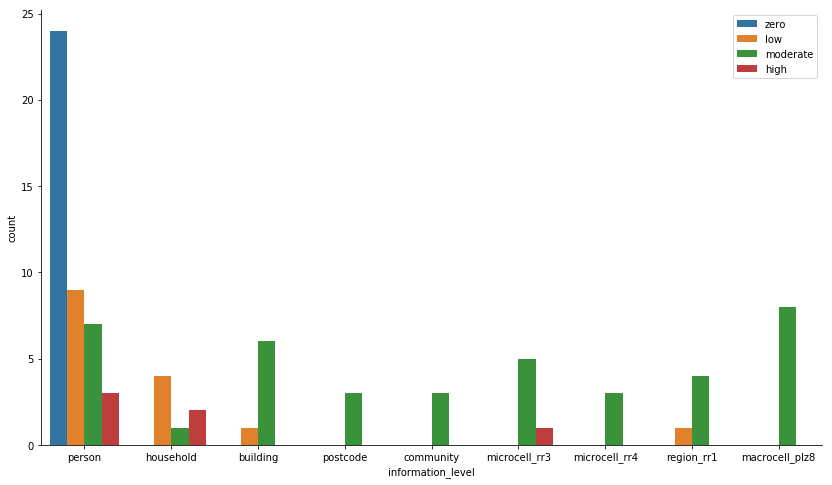

In [30]:
fig, ax1 = plt.subplots(figsize=(14,8))
order = ['person', 'household', 'building', 'postcode', 'community',
       'microcell_rr3', 'microcell_rr4', 'region_rr1', 'macrocell_plz8']
hue_order = ['zero', 'low', 'moderate', 'high']
sns.countplot(data=feat_nan,
              x='information_level',
              hue='nan_cat',
              order=order,
              hue_order=hue_order,
              ax=ax1)
plt.legend(loc='upper right')
sns.despine(ax=ax1);

#### Discussion 1.1.2: Assess Missing Data in Each Column


**General Observations**
- Those data NaN outilers that occur most frequently are only a select few. i.e. ['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']
- There is no feature category(-i.e. person, household, building, postcode, and etc.) without any sort of NaN values.

**Yes, there are patterns in the missing data**
- The least missing data outliers are within a percentage margin of 0% to 20% meaning the most individual's features have the least about of data errors. 
- The person category and household category are the most distributed among all NaN values occurances.
- The moderate/green percentage ratio between 10%-20% are the most evenly distrubted as you can get among all feature categories-i.e. person, household, building, postcode, and etc.
- The zero/blue percentage ratio followed by the low/orange occurs the least among most features categories.  This means alot of the non NaN values occur within the person category.
- High NaN features (>20%) are distributed among person, household and microcell_rr3 information levels.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [31]:
# How much data is missing in each row of the dataset?
azdias['row_nan_perc'] = azdias.isnull().mean(axis=1) 
print(azdias['row_nan_perc'])

0         0.544304
1         0.000000
2         0.000000
3         0.088608
4         0.000000
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
10        0.000000
11        0.594937
12        0.075949
13        0.101266
14        0.594937
15        0.101266
16        0.075949
17        0.594937
18        0.037975
19        0.000000
20        0.126582
21        0.000000
22        0.000000
23        0.101266
24        0.594937
25        0.063291
26        0.240506
27        0.000000
28        0.000000
29        0.025316
            ...   
891191    0.000000
891192    0.000000
891193    0.000000
891194    0.000000
891195    0.000000
891196    0.000000
891197    0.000000
891198    0.000000
891199    0.000000
891200    0.000000
891201    0.000000
891202    0.000000
891203    0.177215
891204    0.000000
891205    0.000000
891206    0.000000
891207    0.000000
891208    0.037975
891209    0.000000
891210    0.000000
891211    0.000000
891212    0.

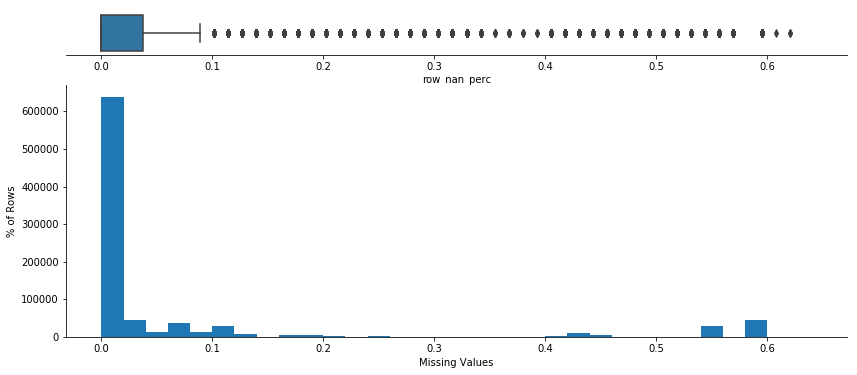

In [32]:
    f, (ax_box, ax_hist) = plt.subplots(2,
                                        sharex=True,
                                        gridspec_kw={
                                            "height_ratios": (.15, .85)},
                                        figsize=(14, 6))

    sns.boxplot(azdias['row_nan_perc'], ax=ax_box)
    bins = np.arange(0, azdias['row_nan_perc'].max() + 0.02, 0.02)
    azdias['row_nan_perc'].hist(grid=False, bins=bins)
    ax_box.set(yticks=[])
    ax_hist.set_ylabel("% of Rows")
    ax_hist.set_xlabel("Missing Values")
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

**Note: about 10% of the data has missing values in the rows**

In [33]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
divider = 0.1

lower_half = azdias.loc[azdias['row_nan_perc'] < divider, :]
higher_half = azdias.loc[azdias['row_nan_perc'] > divider, :]

In [34]:
lower_half.shape


(747109, 80)

In [35]:
higher_half.shape

(144112, 80)

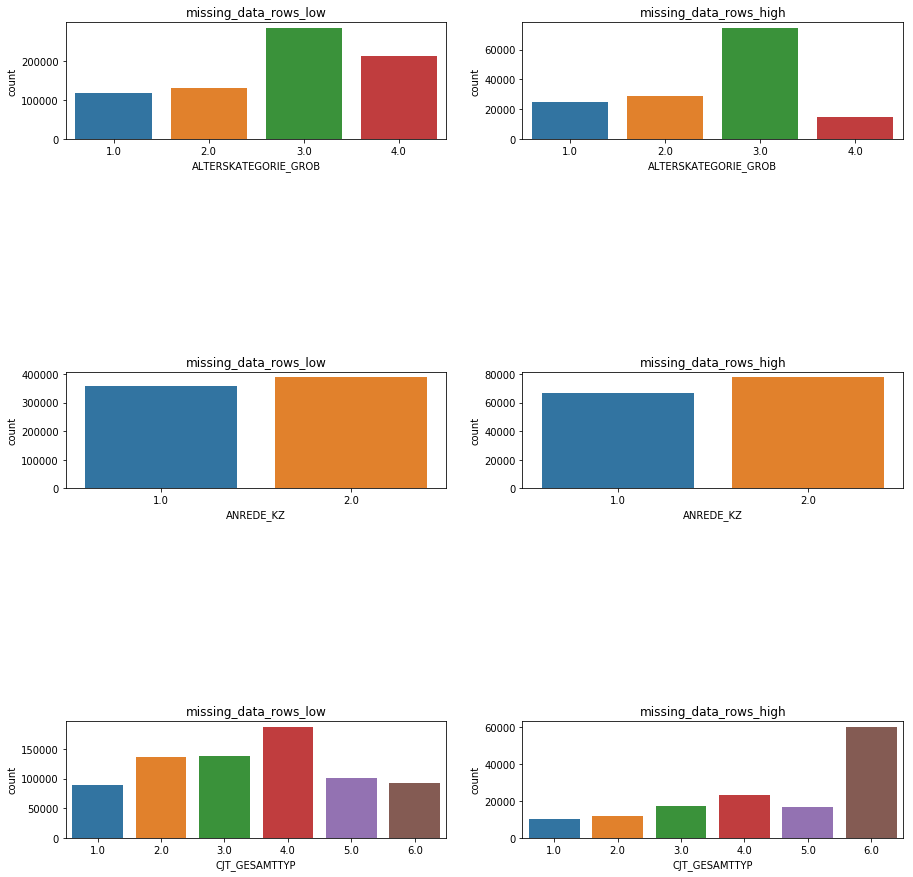

In [36]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def countplot(columns, num):
    fig, axs = plt.subplots(num, 2, figsize=(15, 15))
    fig.subplots_adjust(hspace =2 , wspace=.2)
    axs = axs.ravel()
    
    for i in range(num):
        
        sns.countplot(lower_half[columns[i]], ax=axs[i*2])
        axs[i*2].set_title('missing_data_rows_low')
        sns.countplot(higher_half[columns[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('missing_data_rows_high')
        
countplot(higher_half.columns, 3)

In [37]:
# get a different set of data and get the commmon columns 
common_cols = list(set(lower_half.dropna(axis=1).columns).intersection(higher_half.dropna(axis=1).columns))
common_cols

['SEMIO_ERL',
 'FINANZ_UNAUFFAELLIGER',
 'ZABEOTYP',
 'SEMIO_REL',
 'SEMIO_KULT',
 'SEMIO_KAEM',
 'FINANZ_ANLEGER',
 'ANREDE_KZ',
 'SEMIO_SOZ',
 'SEMIO_MAT',
 'SEMIO_DOM',
 'row_nan_perc',
 'SEMIO_LUST',
 'GREEN_AVANTGARDE',
 'SEMIO_RAT',
 'SEMIO_TRADV',
 'SEMIO_KRIT',
 'FINANZTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_HAUSBAUER',
 'SEMIO_VERT',
 'FINANZ_VORSORGER',
 'SEMIO_FAM',
 'FINANZ_SPARER',
 'SEMIO_PFLICHT']

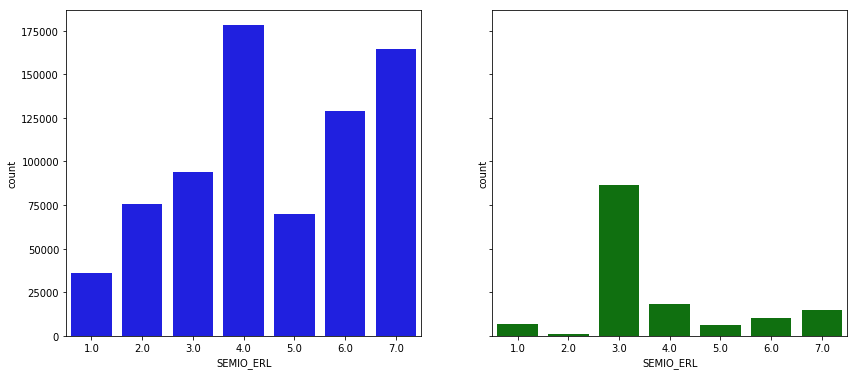

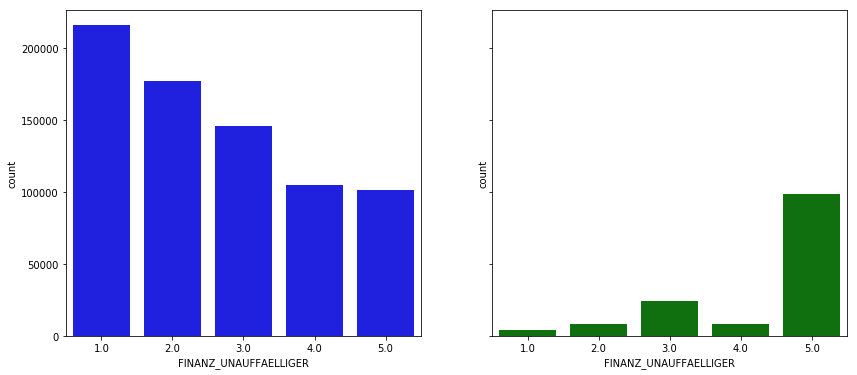

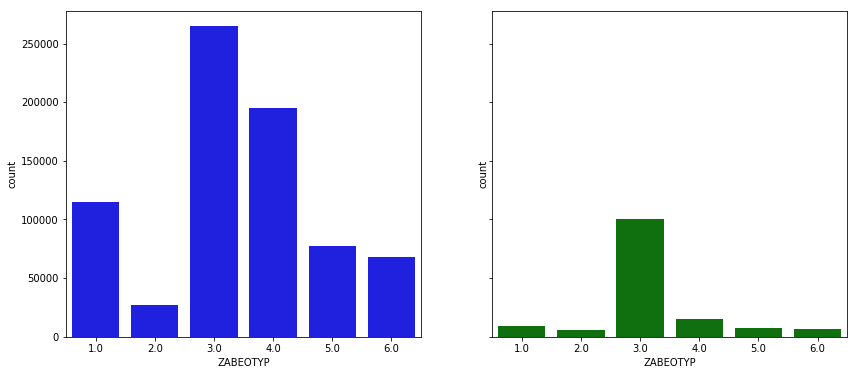

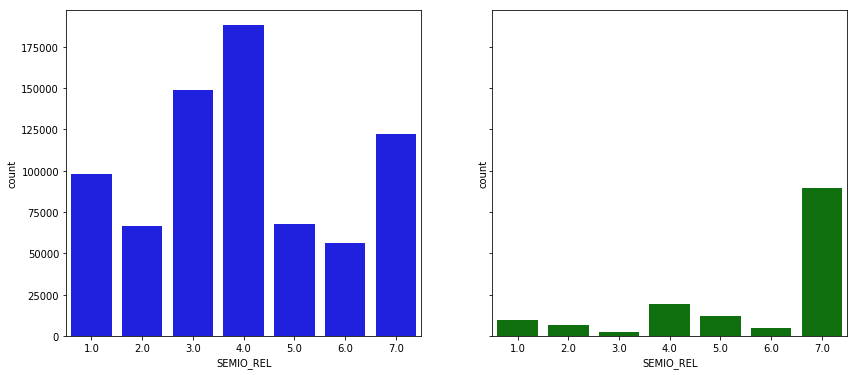

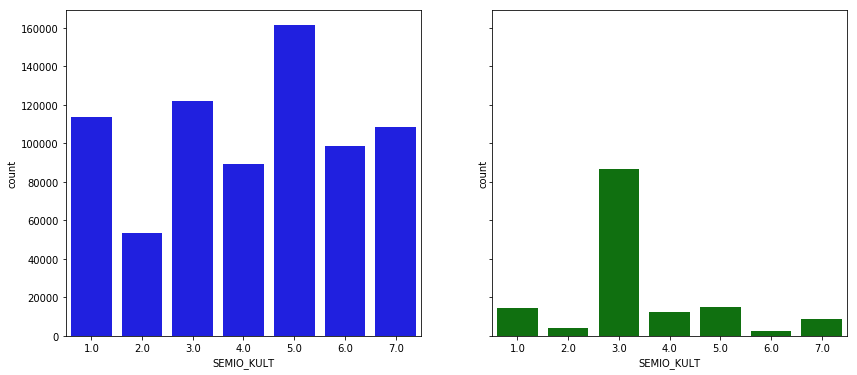

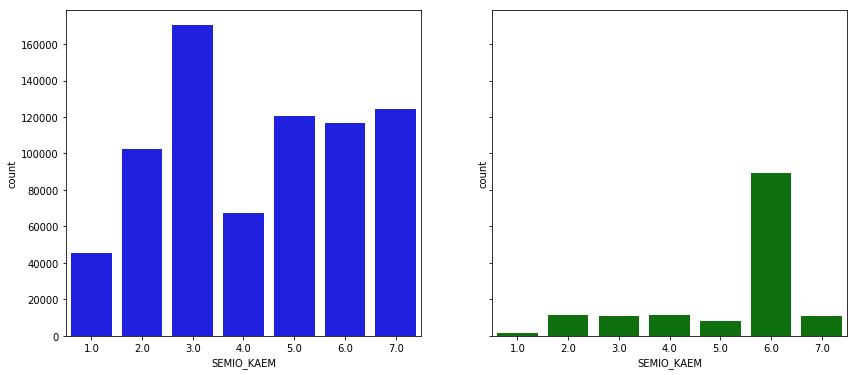

In [38]:
#re-anaylze and re-graph a different set of data
for col in common_cols[:6]:
    fig, axes = plt.subplots(1,2, figsize=(14, 6), sharey=True)
    sns.countplot(lower_half[col], ax=axes[0], color='b')
    sns.countplot(higher_half[col], ax=axes[1], color='g')

In [39]:
#Statistical comparison of distributions
common_cols.remove('row_nan_perc')
for col in common_cols:
    print(col)
    print(chisquare(higher_half[col].value_counts().sort_index(),
                    lower_half[col].value_counts().sort_index(),
                    axis=0),)
    
common_cols.remove('row_nan_perc')
    
    


SEMIO_ERL
Power_divergenceResult(statistic=544795.96052322502, pvalue=0.0)
FINANZ_UNAUFFAELLIGER
Power_divergenceResult(statistic=560081.75457950577, pvalue=0.0)
ZABEOTYP
Power_divergenceResult(statistic=501233.11264447827, pvalue=0.0)
SEMIO_REL
Power_divergenceResult(statistic=530242.37056742061, pvalue=0.0)
SEMIO_KULT
Power_divergenceResult(statistic=526705.83117843466, pvalue=0.0)
SEMIO_KAEM
Power_divergenceResult(statistic=532804.52918348229, pvalue=0.0)
FINANZ_ANLEGER
Power_divergenceResult(statistic=528002.69108647702, pvalue=0.0)
ANREDE_KZ
Power_divergenceResult(statistic=486726.33508461248, pvalue=0.0)
SEMIO_SOZ
Power_divergenceResult(statistic=529546.65265651664, pvalue=0.0)
SEMIO_MAT
Power_divergenceResult(statistic=551804.84833070124, pvalue=0.0)
SEMIO_DOM
Power_divergenceResult(statistic=578605.8437949589, pvalue=0.0)
SEMIO_LUST
Power_divergenceResult(statistic=570363.23141283263, pvalue=0.0)
GREEN_AVANTGARDE
Power_divergenceResult(statistic=491086.21846965601, pvalue=0.0)


ValueError: list.remove(x): x not in list

#### Discussion 1.1.3: Assess Missing Data in Each Row
Are the data with lots of missing values are qualitatively different from data with few or no missing values?

**Observations:**
    - In the first histogram and box and wiskers graph the majority of the rows are within a 10% section of missing data of the whole dataset.
    - When looking at the two sets of double mulitiple graphs(the common names vs the random names), we find in the common names that the lower half and higher half sections are statistically different from each other in all cases.  This essentially means we find that there is a large amount of missing data in the lower half and the same is not true for the higher half. And this observation is also different than the random names graphs, which, in some cases the graphs are similar in missing data in the lower half to higher half.
    -  To make sure this anaylsis was a proper view of the data, I conducted a chisquare test. A chisquare test  tests to see if the expected frequencies are different than the observed frequencies.  In this case, the p value is 0 for all cases, which means there is no differnce and hence these datasets are a representative of the whole data.
    - Therefore in most cases the distrubtions of the lower half and the higher half are different.  There are just a few exceptions with some rows being similar in the lower half to the upper half.
    



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [40]:
print(feat_info)
print(feat_info['type'])


                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical            [-1, 0]
1    ALTERSKATEGORIE_GROB            person      ordinal         [-1, 0, 9]
2               ANREDE_KZ            person  categorical            [-1, 0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

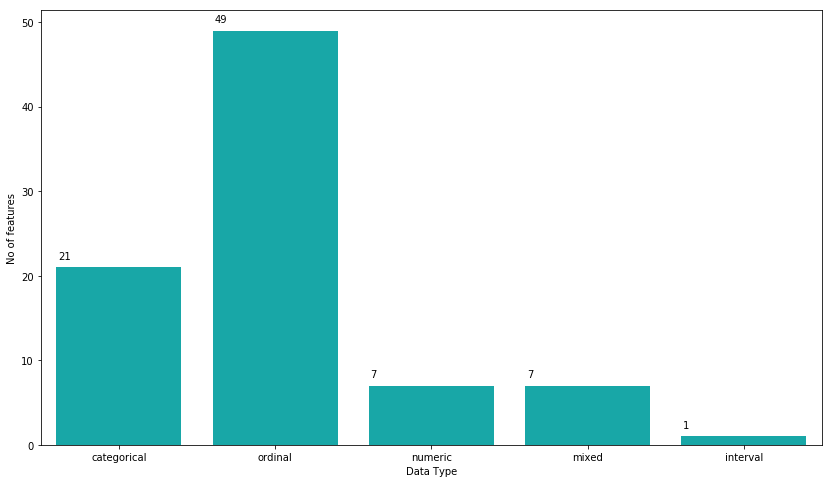

In [41]:
# How many features are there of each data type?

fig, ax1 = plt.subplots(figsize=(14,8))
sns.countplot(data=feat_info,
              x='type',
              color='c',
              ax=ax1)
ax1.set_ylabel('No of features')
ax1.set_xlabel('Data Type')
for p in ax1.patches:
    ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+1))


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [42]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Remove from feat_info dataframe colums that have already been deleted

feat_info = feat_info[feat_info.attribute != 'TITEL_KZ']
feat_info = feat_info[feat_info.attribute != 'AGER_TYP']
feat_info = feat_info[feat_info.attribute != 'KK_KUNDENTYP']
feat_info = feat_info[feat_info.attribute != 'KBA05_BAUMAX']
feat_info = feat_info[feat_info.attribute != 'GEBURTSJAHR']
feat_info = feat_info[feat_info.attribute != 'ALTER_HH']

In [43]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_info[feat_info.type == 'categorical']


,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1, 0]"


In [44]:
# Create a dataframe with only categorical variables
categorical_variables = azdias[feat_info[feat_info['type'] == 'categorical']['attribute']]
categorical_variables

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,1.0,2.0,4.0,10.0,0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
1,2.0,5.0,1.0,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,W,8,8A
2,2.0,3.0,1.0,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,W,4,4C
3,2.0,2.0,6.0,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3.0,1.0,W,2,2A
4,1.0,5.0,5.0,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,1.0,W,6,6B
5,2.0,2.0,2.0,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,1.0,W,8,8C
6,2.0,5.0,4.0,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4.0,1.0,W,4,4A
7,1.0,3.0,5.0,9.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,8.0,W,2,2D
8,1.0,3.0,6.0,3.0,1,1.0,1.0,10.0,5.0,1.0,3.0,0.0,2.0,6.0,3.0,W,1,1A
9,2.0,4.0,1.0,12.0,1,1.0,1.0,3.0,2.0,1.0,3.0,0.0,2.0,4.0,3.0,W,1,1E


In [45]:
feat_info[feat_info.type == 'categorical'].groupby('information_level').count().iloc[:,-1]


information_level
building          2
microcell_rr4     2
person           14
Name: missing_or_unknown, dtype: int64

In [46]:
select_columns = feat_info[feat_info.type == 'categorical'].type
select_columns

2     categorical
3     categorical
10    categorical
12    categorical
13    categorical
17    categorical
18    categorical
19    categorical
20    categorical
21    categorical
38    categorical
39    categorical
41    categorical
42    categorical
52    categorical
55    categorical
57    categorical
58    categorical
Name: type, dtype: object

In [47]:
feat_info['type'].dtypes

dtype('O')

In [48]:
#for var in feat_info:
    #data = feat_info[var]
    
    #print('Column: {}'.format(var))

    #print('  # unique values: {}'.format(data.unique()))
    

In [49]:
# Separate the categorical variables into binary or multi-variable
binary = []
multivar = []
for x in categorical_variables:
    if len(categorical_variables[x].value_counts()) == 2:
        binary.append(x)
    else:
        multivar.append(x)

In [50]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [51]:
multivar

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [52]:
feat_info[feat_info.type == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [53]:
select_columns_mix = feat_info[feat_info.type == 'mixed'].type

In [54]:
#Drop multi-variable columns not required
cols_to_drop = ['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']
azdias_2 = azdias.drop(cols_to_drop,axis=1)

In [55]:
def ew_to_num(x): 
    val_map = {'O':0, 'W':1}
    try: 
        return val_map[x]
    except:
        return np.nan
        

azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].apply(ew_to_num)

In [56]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_2 = pd.get_dummies(azdias)

In [57]:
azdias_2

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_INTL_2015_34,CAMEO_INTL_2015_35,CAMEO_INTL_2015_41,CAMEO_INTL_2015_43,CAMEO_INTL_2015_44,CAMEO_INTL_2015_45,CAMEO_INTL_2015_51,CAMEO_INTL_2015_52,CAMEO_INTL_2015_54,CAMEO_INTL_2015_55
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,0,0,0,0,0,0,1,0,0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0,0,0,1,0,0,0,0,0,0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,0,0,0,0,0,0,0,0,1,0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
8,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,...,0,0,0,0,0,0,0,0,0,0
9,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

I removed certain columns in feat_info that were removed previously in azidas to make the data set equal for comparison later.  

I examined the data types and furthermore separated binary types from multivar types.  

I decided to delete the multivar types from the dataset.  The reason being, this type of data is really hard to re-encode and configure to match other data to be examined.  This information also tells much information that is too particular for me in this analysis of customer segmentation.  This particular analysis is not relevant at this stage and may cause an overfitting analysis.

For instance, the multivar category "GEBAEUDETYP" would provide no additional value for customer segmentation as it related to building-level feature. 

Another instance, “CAMEO_DEU_2015” provides too specific and weird categories for some Wealth / Life Stage typology segments.  It has segments such as “Noble Jogger” and “Petty Bourgeois”.  The data ranges from a scale of 1-9 with alphabetical categories at each scale.

I then preformed panda’s get get_dummies on the data of azdias and made it into a new variable.  This is to make the data easily comparable for further study.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [58]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias['PRAEGENDE_JUGENDJAHRE'].unique()

array([ nan,  14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,
         2.,   1.,  12.,  13.,   7.])

In [59]:
azdias.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

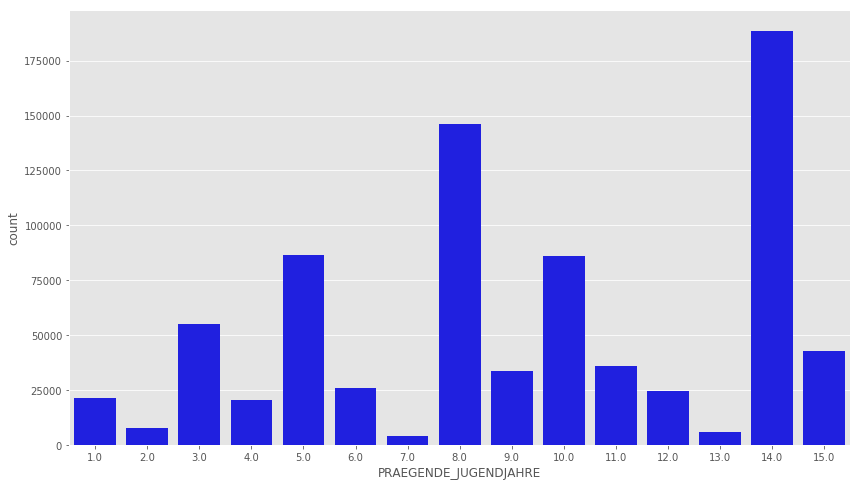

In [60]:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(14,8))
sns.countplot(data=azdias,
              x='PRAEGENDE_JUGENDJAHRE',
              color="blue",
              ax=ax1);

New Variables Data encoding:

 **ENG_DECADE:**

Person’s decade of youth.

- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s

**ENG_MOVEMENT:**

Person’s movement alignment.

- 1: Mainstream
- 2: Avantgarde

In [61]:
decade_dict = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
               8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
               14: 6, 15: 6
              }
movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                }

azdias_2['ENG_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
azdias_2['ENG_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)

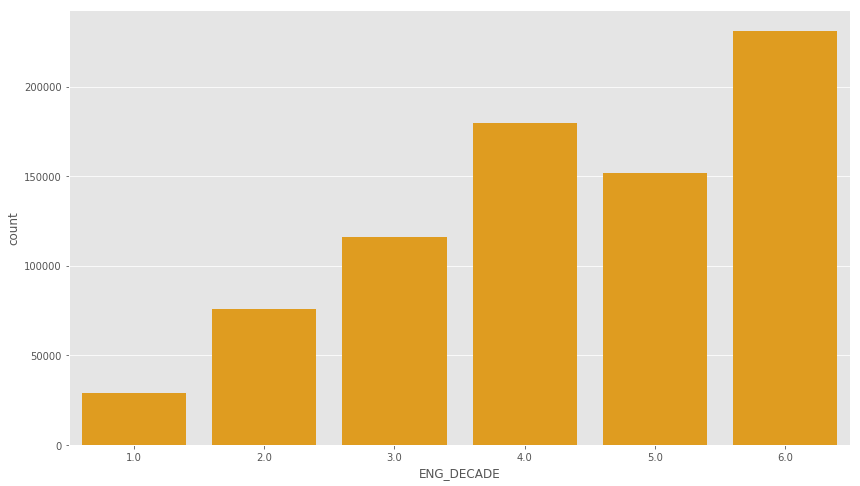

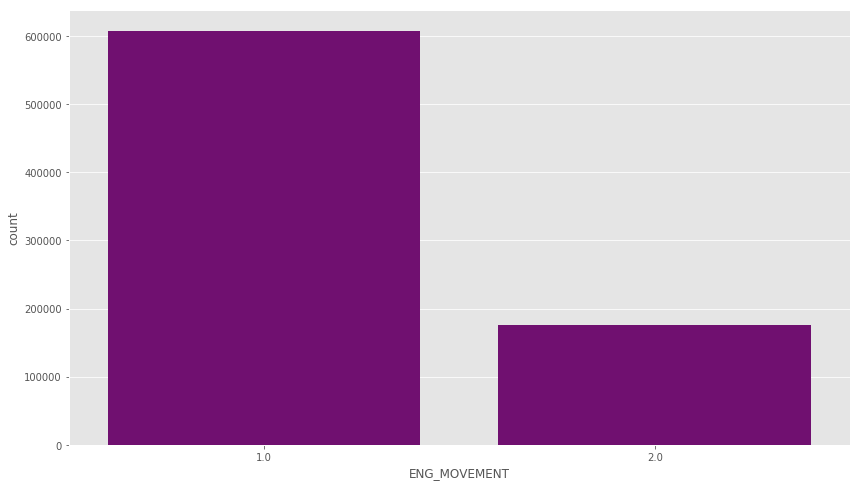

In [62]:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(14,8))
sns.countplot(data=azdias_2,
              x='ENG_DECADE',
              color="orange",
              ax=ax1);

plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(14,8))
sns.countplot(data=azdias_2,
              x='ENG_MOVEMENT',
              color="purple",
              ax=ax1);

In [63]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_2015'].unique()


array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

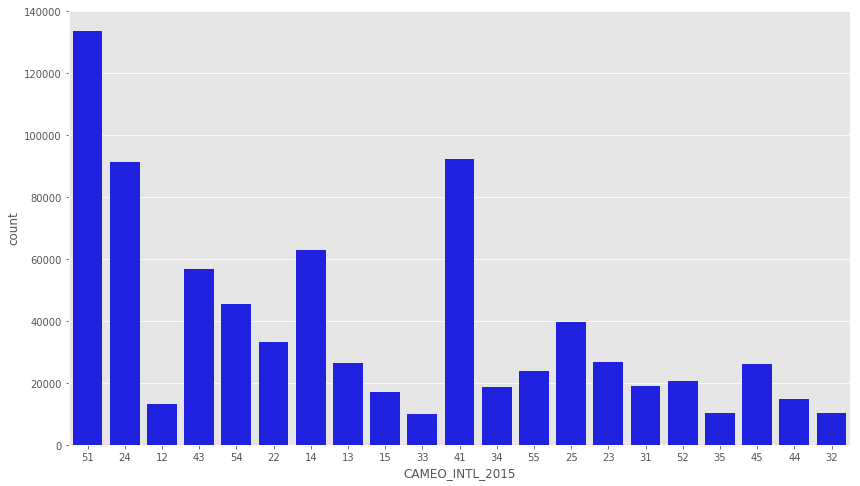

In [64]:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(14,8))
sns.countplot(data=azdias,
              x='CAMEO_INTL_2015',
              color="blue",
              ax=ax1);



### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

New Variables Data encoding:
- **Household economic status:**
- 1: Wealthy Households
- 2: Prosperous Households
- 3: Comfortable Households
- 4: Less Affluent Households
- 5: Poorer Households

- **Family type:**
- 1: Pre-Family Couples & Singles
- 2: Young Couples With Children
- 3: Families With School Age Children
- 4: Older Families & Mature Couples
- 5: Elders In Retirement




In [65]:
#task: break up the CAMEO_INTL_2015 double digits and remove the first digit and second digit into two different lists.  
#This will be equivallent to the new data encoding list.
def break_up_digits(x, digit):
    if not pd.isna(x):
        if digit == 'first':
            return int(str(x)[0])
        elif digit == 'second':
            return int(str(x)[1])
    return x


azdias_2['household_economic_status_dic'] = azdias['CAMEO_INTL_2015'].apply(break_up_digits, digit ='first')
azdias_2['family_type_dic'] = azdias['CAMEO_INTL_2015'].apply(break_up_digits, digit ='second')

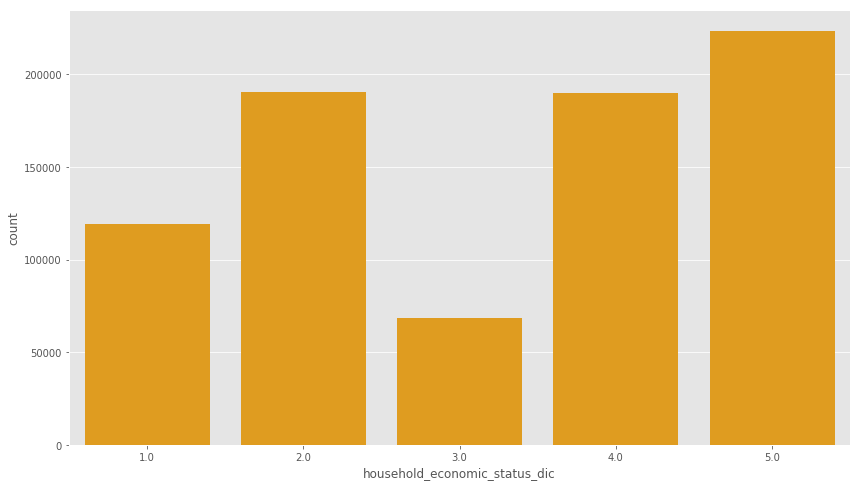

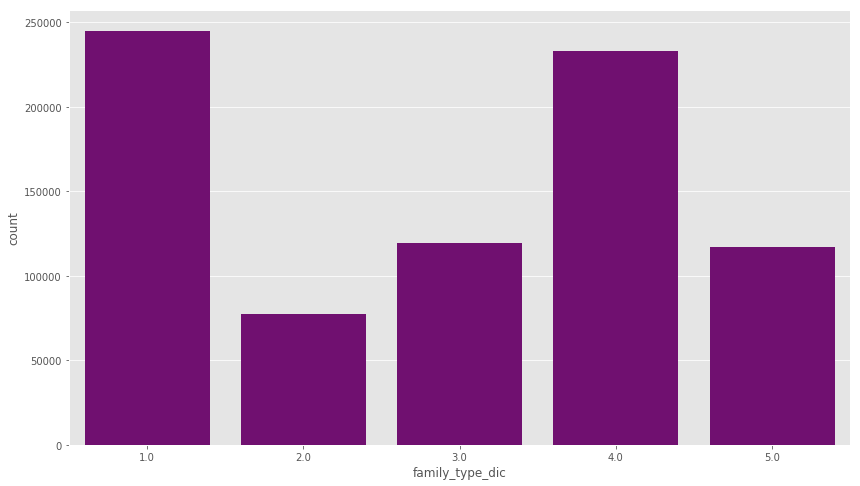

In [66]:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(14,8))
sns.countplot(data=azdias_2,
              x='household_economic_status_dic',
              color="orange",
              ax=ax1);

plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(14,8))
sns.countplot(data=azdias_2,
              x='family_type_dic',
              color="purple",
              ax=ax1);

#### Discussion 1.2.2: Engineer Mixed-Type Features

As there was a lot of data, I tried to focus on simple variables that could tell the right amount without being too nitty gritty.

For PRAEGENDE_JUGENDJAHRE (age, avantgarde vs. mainstream; east vs. west), I decided to cluster via age.  Age is an important factor and cand determine a lot.  When the new encoded age was graphed, the results show the majority of people are in digit 90s then 70s.  I decided to encode the movement political thought and ideas.  This is easily seperatable.  I got rid of the specifics of each movement, as it does not tell me much.  When the new encoded movement is graphed, the results show the majority are or have mainstream ideas and thoughts.

For CAMEO_INTL_2015 (wealth or lifestage), I decided to cluster wealth into simpler categories with still getting the right amount.  When this new variable is graphed, the results show a minority are living just comfortably.  There is  a near equal division between prosperous and less affluent/poor.  I decided to encode family type and keep it seperate from economic status and simplier.  When this new variable is graphed, the results show a majority of Germans are either single/or a couple, with the next close majority being Germans with old families and mature couples.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [67]:
#delete specific columns that are not needed-i.e. PRAEGENDE_JUGENDJAHRE
azdias_2[:1].transpose()
#del azdias_2['PRAEGENDE_JUGENDJAHRE']
#del azdias_2['CAMEO_INTL_2015_44', 'CAMEO_INTL_2015_45', 'CAMEO_INTL_2015_51', 'CAMEO_INTL_2015_52', 'CAMEO_INTL_2015_54', 'CAMEO_INTL_2015_55']

,0
ALTERSKATEGORIE_GROB,2.0
ANREDE_KZ,1.0
CJT_GESAMTTYP,2.0
FINANZ_MINIMALIST,3.0
FINANZ_SPARER,4.0
FINANZ_VORSORGER,3.0
FINANZ_ANLEGER,5.0
FINANZ_UNAUFFAELLIGER,5.0
FINANZ_HAUSBAUER,3.0
FINANZTYP,4.0


In [68]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


for var in azdias_2:
    data = azdias_2[var]
    print('Column: {}'.format(var))

    print('  # unique values: {}'.format(data.unique()))


Column: ALTERSKATEGORIE_GROB
  # unique values: [  2.   1.   3.   4.  nan]
Column: ANREDE_KZ
  # unique values: [ 1.  2.]
Column: CJT_GESAMTTYP
  # unique values: [  2.   5.   3.   4.   1.   6.  nan]
Column: FINANZ_MINIMALIST
  # unique values: [ 3.  1.  4.  2.  5.]
Column: FINANZ_SPARER
  # unique values: [ 4.  5.  2.  3.  1.]
Column: FINANZ_VORSORGER
  # unique values: [ 3.  2.  1.  5.  4.]
Column: FINANZ_ANLEGER
  # unique values: [ 5.  2.  1.  4.  3.]
Column: FINANZ_UNAUFFAELLIGER
  # unique values: [ 5.  4.  3.  1.  2.]
Column: FINANZ_HAUSBAUER
  # unique values: [ 3.  5.  2.  4.  1.]
Column: FINANZTYP
  # unique values: [ 4.  1.  6.  5.  2.  3.]
Column: GFK_URLAUBERTYP
  # unique values: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
Column: GREEN_AVANTGARDE
  # unique values: [0 1]
Column: HEALTH_TYP
  # unique values: [ nan   3.   2.   1.]
Column: LP_LEBENSPHASE_FEIN
  # unique values: [ 15.  21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   

In [69]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_2.to_csv('azdias_checkpoint_2.csv',sep=';',encoding='utf-8',index=False)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [70]:
#calling outside function for clean_data
def map_wealth(x):
    # Check of nan first, or it will convert nan to string 'nan'
    if pd.isnull(x):
        return np.nan
    else:
        return (str(x)[0])

# Map life stage
def map_lifestage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return (str(x)[1])

In [71]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    df_copy = df.copy()
    
    # convert missing value codes into NaNs, ... 
            
    
    # turn missing_or_unknown to list 
    # convert missing value codes into NaNs, ...
    #def is_int(value):
      #try:
        #int(value)
        #return True
      #except ValueError:
        #return False
    #data_dict = {'nan_vals': feat_info['missing_or_unknown'] \
             #.str.replace('[','').str.replace(']','').str.split(',').values}
    
    #missing_vals = pd.DataFrame(data_dict, index = feat_info['attribute'].values)

    #missing_vals['nan_vals'] = missing_vals.apply(lambda x: [int(i) if is_int(i) == True else i for i in x[0]], axis=1)
    
    for column in df.columns:
        df[column] = df[column].replace(missing_vals.loc[column][0], np.nan) 
      
    #for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        #if missing_values[0] != '':
            #for value in missing_values:
                #if value.isnumeric() or value.lstrip('-').isnumeric():
                    #value = int(value)
                #df_copy.loc[df_copy[attrib] == value] = np.nan
    
    #missing_data_encode = dict(zip(df_copy))
    #for col in missing_data_encode.keys():
        #nans_before = df[col].isnull().sum()
        #df.loc[df[col].isin(missing_data_encode[col]), col] = np.nan
    print("Identified missing or unknown data values and converted them to NaNs.")
    

    
    # remove selected columns and rows, ...
    
    c_remove = (['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'])
    
    df_copy.drop(c_remove, axis=1, inplace=True)
        
    df_copy = df_copy[df_copy.isnull().sum(axis=1) < 10].reset_index(drop=True)
    
    for col in df_copy.columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])
    
    # Separate the categorical variables into binary or multi-variable
    categorical_variables = azdias[feat_info[feat_info['type'] == 'categorical']['attribute']]

    binary = []
    multivar = []
    for x in categorical_variables:
        if len(categorical_variables[x].value_counts()) == 2:
            binary.append(x)
        else:
            multivar.append(x)
    
    cols_to_drop = multivar
   
    
    mixed = ['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']
    
    df_copy.drop(mixed, axis=1, inplace=True)
        
    print("Removed selected columns and rows")
    
    pd.get_dummies(df_copy)
    
    df_copy['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    
    # select, re-encode, and engineer column values.            
    decade_dict = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
               8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
               14: 6, 15: 6
              }
    movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                }

    df_copy['ENG_DECADE'] = df_copy['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df_copy['ENG_MOVEMENT'] = df_copy['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    # Map wealth 
    df_copy['CAMEO_INTL_2015_wealth'] = df_copy['CAMEO_INTL_2015'].map(map_wealth)
    df_copy['CAMEO_INTL_2015_lifestage'] = df_copy['CAMEO_INTL_2015'].map(map_lifestage)
    
    df_copy.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    
    print("Selected, re-encoded, and engineered column values")
    
    # Return the cleaned dataframe.
    return df_copy
    

In [72]:
clean_data(azdias_for_later)

Identified missing or unknown data values and converted them to NaNs.
Removed selected columns and rows
Selected, re-encoded, and engineered column values


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ENG_DECADE,ENG_MOVEMENT,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,1,2,1,5,2,5,4,5,0,3,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5,1
1,3,2,1,4,1,2,3,5,1,3,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2,4
2,4,2,4,2,5,2,1,2,0,2,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1,2
3,3,1,4,3,4,1,3,2,0,3,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4,3
4,1,2,3,1,5,2,2,5,0,3,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5,4
5,2,2,1,5,1,5,4,3,0,2,...,1.0,5.0,5.0,4.0,6.0,3.0,5.0,1.0,2,2
6,1,1,3,3,4,1,3,2,0,1,...,1.0,4.0,4.0,2.0,5.0,2.0,4.0,1.0,1,4
7,3,1,4,4,2,4,2,2,1,3,...,1.0,3.0,3.0,2.0,4.0,3.0,5.0,2.0,1,3
8,3,2,2,4,2,3,5,4,1,2,...,1.0,3.0,3.0,2.0,3.0,1.0,6.0,2.0,1,5
9,3,2,2,2,5,3,1,5,0,2,...,2.0,3.0,3.0,4.0,6.0,5.0,2.0,1.0,5,1


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [98]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_2.isnull().mean().sort_values(ascending=False)

#for col in missing_data.columns:
    #missing_data[col] = missing_data[col].fillna(missing_data[col].model()[0])


REGIOTYP                         0.177357
KKK                              0.177357
W_KEIT_KIND_HH                   0.166051
KBA05_ANTG1                      0.149597
MOBI_REGIO                       0.149597
KBA05_ANTG2                      0.149597
KBA05_GBZ                        0.149597
KBA05_ANTG4                      0.149597
KBA05_ANTG3                      0.149597
PLZ8_GBZ                         0.130736
PLZ8_HHZ                         0.130736
PLZ8_BAUMAX                      0.130736
PLZ8_ANTG3                       0.130736
PLZ8_ANTG2                       0.130736
PLZ8_ANTG1                       0.130736
PLZ8_ANTG4                       0.130736
HEALTH_TYP                       0.124768
SHOPPER_TYP                      0.124768
VERS_TYP                         0.124768
NATIONALITAET_KZ                 0.121536
PRAEGENDE_JUGENDJAHRE            0.121366
ENG_DECADE                       0.121366
ENG_MOVEMENT                     0.121366
KBA13_ANZAHL_PKW                 0

In [74]:
#fit the scaler, no NaNs
from sklearn.preprocessing import StandardScaler
azdias_drop = azdias_2.dropna(axis=0)
scaler = StandardScaler()
scaler.fit(azdias_drop)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [75]:
from sklearn.preprocessing import Imputer
#Imputer will depreciate soon, if it does not work import SimpleImputer
imputer = Imputer(missing_values='NaN', strategy='mean')
azdias_3 = imputer.fit_transform(azdias_2)
azdias_3 = pd.DataFrame(azdias_2)
azdias_3.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_INTL_2015_44,CAMEO_INTL_2015_45,CAMEO_INTL_2015_51,CAMEO_INTL_2015_52,CAMEO_INTL_2015_54,CAMEO_INTL_2015_55,ENG_DECADE,ENG_MOVEMENT,household_economic_status_dic,family_type_dic
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,0,0,1,0,0,0,6.0,1.0,5.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0,0,0,0,0,0,6.0,2.0,2.0,4.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,0,0,0,0,0,0,4.0,1.0,1.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0,0,0,0,0,0,4.0,1.0,4.0,3.0


In [76]:
# How many nans as perc after?
print('Total percentage of Nans after  drop: ',
      round(azdias_drop.isnull().sum().sum() / np.product(azdias_drop.shape) * 100, 2),
      '%')

Total percentage of Nans after  drop:  0.0 %


### Discussion 2.1: Apply Feature Scaling

There were a few missing values. I took out all of the Nans, dropped them, and rescaled them with StandardScaler.  Then I used Imputer to replace all missing values with a mean based off the new scale.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [77]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score



In [78]:
missing_data_rows_high = azdias_3[azdias_3.isnull().sum(axis = 1) >= 10].reset_index(drop=True)
missing_data_rows_low = azdias_3[azdias_3.isnull().sum(axis=1) < 10].reset_index(drop=True)

In [79]:
# Fill the Nan values with the mode of that respective column.
for col in missing_data_rows_low.columns:
        missing_data_rows_low[col] = missing_data_rows_low[col].fillna(missing_data_rows_low[col].mode()[0])
# Apply feature scaling to the general population demographics data.
normalizer = StandardScaler()
missing_data_rows_low[missing_data_rows_low.columns] = normalizer.fit_transform(missing_data_rows_low[missing_data_rows_low.columns])
missing_data_rows_low.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_INTL_2015_44,CAMEO_INTL_2015_45,CAMEO_INTL_2015_51,CAMEO_INTL_2015_52,CAMEO_INTL_2015_54,CAMEO_INTL_2015_55,ENG_DECADE,ENG_MOVEMENT,household_economic_status_dic,family_type_dic
0,-1.753099,0.962959,0.990414,-1.510923,1.563306,-1.046320,1.490678,0.996534,1.341295,-1.368228,...,-0.138094,-0.185179,2.214455,-0.162875,-0.247313,-0.176528,1.121214,-0.535286,1.174062,-1.252821
1,0.201643,0.962959,-0.313382,-1.510923,0.886386,-1.770348,-0.558273,0.276471,1.341295,-1.368228,...,-0.138094,-0.185179,-0.451578,-0.162875,-0.247313,-0.176528,1.121214,1.868159,-0.870598,0.761420
2,1.179014,0.962959,-0.965281,0.678797,-0.467454,1.125766,-0.558273,-1.163656,-0.808541,1.033590,...,-0.138094,-0.185179,-0.451578,-0.162875,-0.247313,-0.176528,-0.246094,-0.535286,-1.552152,-0.581407
3,0.201643,-1.038466,0.990414,0.678797,0.209466,0.401737,-1.241257,0.276471,-0.808541,0.553227,...,-0.138094,-0.185179,-0.451578,-0.162875,-0.247313,-0.176528,-0.246094,-0.535286,0.492508,0.090007
4,-1.753099,0.962959,-0.965281,-0.051110,-1.144374,1.125766,-0.558273,-0.443592,1.341295,-0.887864,...,-0.138094,-0.185179,-0.451578,-0.162875,4.043452,-0.176528,-1.613401,-0.535286,1.174062,0.761420


In [80]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = data
    random_state = 40
    pca = PCA(n_components, random_state=random_state)
    X_pca = pca.fit_transform(X)
    return pca, X_pca



In [81]:
pca = PCA().fit(missing_data_rows_low)

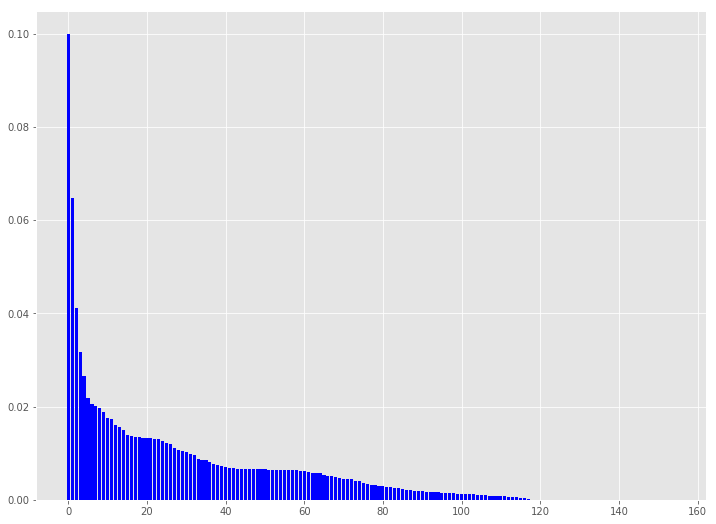

In [82]:
num_components=len(pca.explained_variance_ratio_)
inds = np.arange(num_components)
vals = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(12,9))
plt.bar(inds, vals, color='b');

In [83]:
# Apply PCA to the data
#random_state = 40
#pca = PCA(random_state=random_state)
#pca.fit(df_scale)

**120 stands out as an ending mark**

In [84]:
# Re-apply PCA to the data while selecting for number of components to retain.



In [85]:
do_pca(120, missing_data_rows_low)

(PCA(copy=True, iterated_power='auto', n_components=120, random_state=40,
   svd_solver='auto', tol=0.0, whiten=False),
 array([[  4.33307221e+00,  -3.60342586e+00,  -2.91027836e+00, ...,
          -2.98034138e-02,   2.65484715e-02,  -2.98596581e-02],
        [ -6.50297795e-01,  -4.33699385e-01,  -3.65012846e+00, ...,
           7.04754454e-03,  -4.71641900e-02,  -3.47609615e-02],
        [ -4.37840002e+00,   1.83212055e+00,  -7.31558186e-01, ...,
          -5.78872740e-02,  -4.86448753e-02,  -6.45236590e-02],
        ..., 
        [ -9.35707975e-01,  -3.59505721e+00,  -3.15183032e+00, ...,
          -7.71239178e-02,  -1.22857388e-01,   5.28954282e-03],
        [  5.95528224e+00,  -4.43066285e+00,   2.82771732e+00, ...,
           3.55233288e-03,   7.89515430e-02,  -3.10250366e-02],
        [  2.40402172e-01,   2.31750460e+00,   2.77811841e+00, ...,
          -2.24251049e-02,  -1.71024609e-03,   2.50482499e-02]]))

In [86]:
pca, X_pca = do_pca(70, missing_data_rows_low)


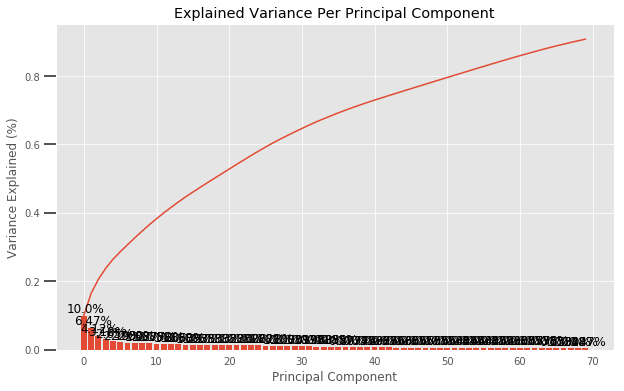

In [87]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

A key aspect in this pca analysis was inserting "random_state = 40" as to make this test repeatable and replicable.  Hence, someone else could get the same findings as me.  If there were no random_state there would be variance.

I first decided to take 120 principle components as my pca.explained_variance_ratio_ graph showed. However, later on in in this assignment project, when doing pca for the general population, I found that there were only 70 components and I could not go over 70. In order to make both the customer population and the general population comparable, I used 70 components for both analyses.

This makes sence as when you start going in a high number of principle components, eventually, a high number becomes useless. As the graph shows, the variance per each higher principle component declines and eventually levels. As you can see principle component 45 has the same variance as principle component 70 or 120. Hence more does not mean better.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [88]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# function for an n_component pca weighted analysis
def map_pca_weights_to_feats(pca, df, comp_no):
    '''Map pca weights to  individual features
    and return two pd.Series on with the highest
    positive weights and one with the lowest negative
    weights'''

    weights = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys())
    component = weights.iloc[comp_no - 1, :]
    comp_pos = component[component > 0].sort_values(ascending=False)
    comp_neg = component[component < 0].sort_values(ascending=True)

    return comp_pos, comp_neg


In [89]:
# graph for an n_component pca weighted analysis, restricted to the top 15 values

from IPython.core.display import HTML
def create_bar_table(comp_pos, comp_neg):
    '''Create and display a conditionally styled pandas dataframe
    for the interpertation of the positive and negative weights
    of PCA and centroid distances for KMeans'''
    
    head = """
    <table>
    """
    row = ""
    for serie in [comp_pos[:15],comp_neg[:15]]:
        s = serie.copy()
        s.name=''
        row += "<td>{}</td>".format(s.to_frame().style.bar(
                                                           align='mid',
                                                           color=['#d65f5f', '#5fba7d'],
                                                           width=100).render()
                                   ) 
    row += '</tr>'
    head += row

    head+= """
    </table>"""

    display(HTML(head))

In [90]:
# function for a whole pca weighted analysis
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,CAMEO_INTL_2015_44,CAMEO_INTL_2015_45,CAMEO_INTL_2015_51,CAMEO_INTL_2015_52,CAMEO_INTL_2015_54,CAMEO_INTL_2015_55,ENG_DECADE,ENG_MOVEMENT,household_economic_status_dic,family_type_dic
Dimension 1,0.1000,-0.0702,0.0105,0.0258,-0.1784,0.0968,-0.0700,0.0369,0.0374,0.1484,...,0.0017,0.0128,0.1312,0.0374,0.0416,0.0346,0.0618,-0.1026,0.1927,-0.1131
Dimension 2,0.0648,0.2550,0.0530,-0.1255,0.1053,-0.2475,0.2352,-0.2123,-0.2299,0.0812,...,0.0071,0.0348,0.0081,-0.0113,0.0230,0.0556,-0.2530,-0.0004,0.0452,0.0279
Dimension 3,0.0412,0.0404,-0.3644,-0.0203,0.1470,-0.0733,0.0668,-0.1588,-0.0713,-0.0589,...,-0.0020,0.0066,0.0325,-0.0049,-0.0020,0.0019,-0.0779,0.0555,0.0213,-0.0135
Dimension 4,0.0318,-0.0133,0.0466,0.0642,0.0228,-0.0007,-0.0098,-0.0618,0.0212,-0.0384,...,-0.0088,-0.0068,0.0198,0.0140,-0.0061,-0.0143,0.0233,0.2187,-0.0367,0.0048
Dimension 5,0.0265,0.0562,-0.0220,0.0064,0.0090,-0.0206,0.0348,0.0593,-0.0891,0.0153,...,-0.0047,0.0160,0.0692,0.0753,0.0486,0.0314,-0.0248,-0.1800,0.1665,-0.0872
Dimension 6,0.0219,-0.0303,-0.0006,0.0057,-0.0327,0.0086,-0.0117,-0.0020,0.0111,0.0482,...,0.1709,0.2080,-0.1816,-0.0483,0.0444,0.0223,-0.0017,0.0114,0.0683,0.2598
Dimension 7,0.0205,-0.0256,0.0059,0.0058,-0.0079,0.0097,-0.0247,0.0119,-0.0067,0.0129,...,-0.0202,0.0175,0.0778,0.0584,0.0136,0.1159,0.0061,0.0119,-0.0775,0.2887
Dimension 8,0.0201,0.0033,-0.0070,0.0071,0.0016,-0.0054,0.0038,-0.0367,0.0207,-0.0042,...,-0.0550,-0.0537,-0.1310,-0.0822,0.0411,-0.0160,0.0045,0.0356,0.0005,0.0197
Dimension 9,0.0197,0.0146,0.0017,-0.0065,0.0101,-0.0028,0.0101,0.0033,-0.0040,-0.0184,...,-0.0004,-0.0352,0.1449,0.1036,-0.1702,-0.0271,-0.0013,-0.0144,-0.0073,-0.0595
Dimension 10,0.0188,0.0136,-0.0025,0.0050,0.0228,-0.0026,0.0375,-0.0532,0.0266,-0.0416,...,0.0566,-0.0318,0.1336,0.0571,-0.1888,-0.1452,-0.0053,0.0726,0.0252,-0.1754


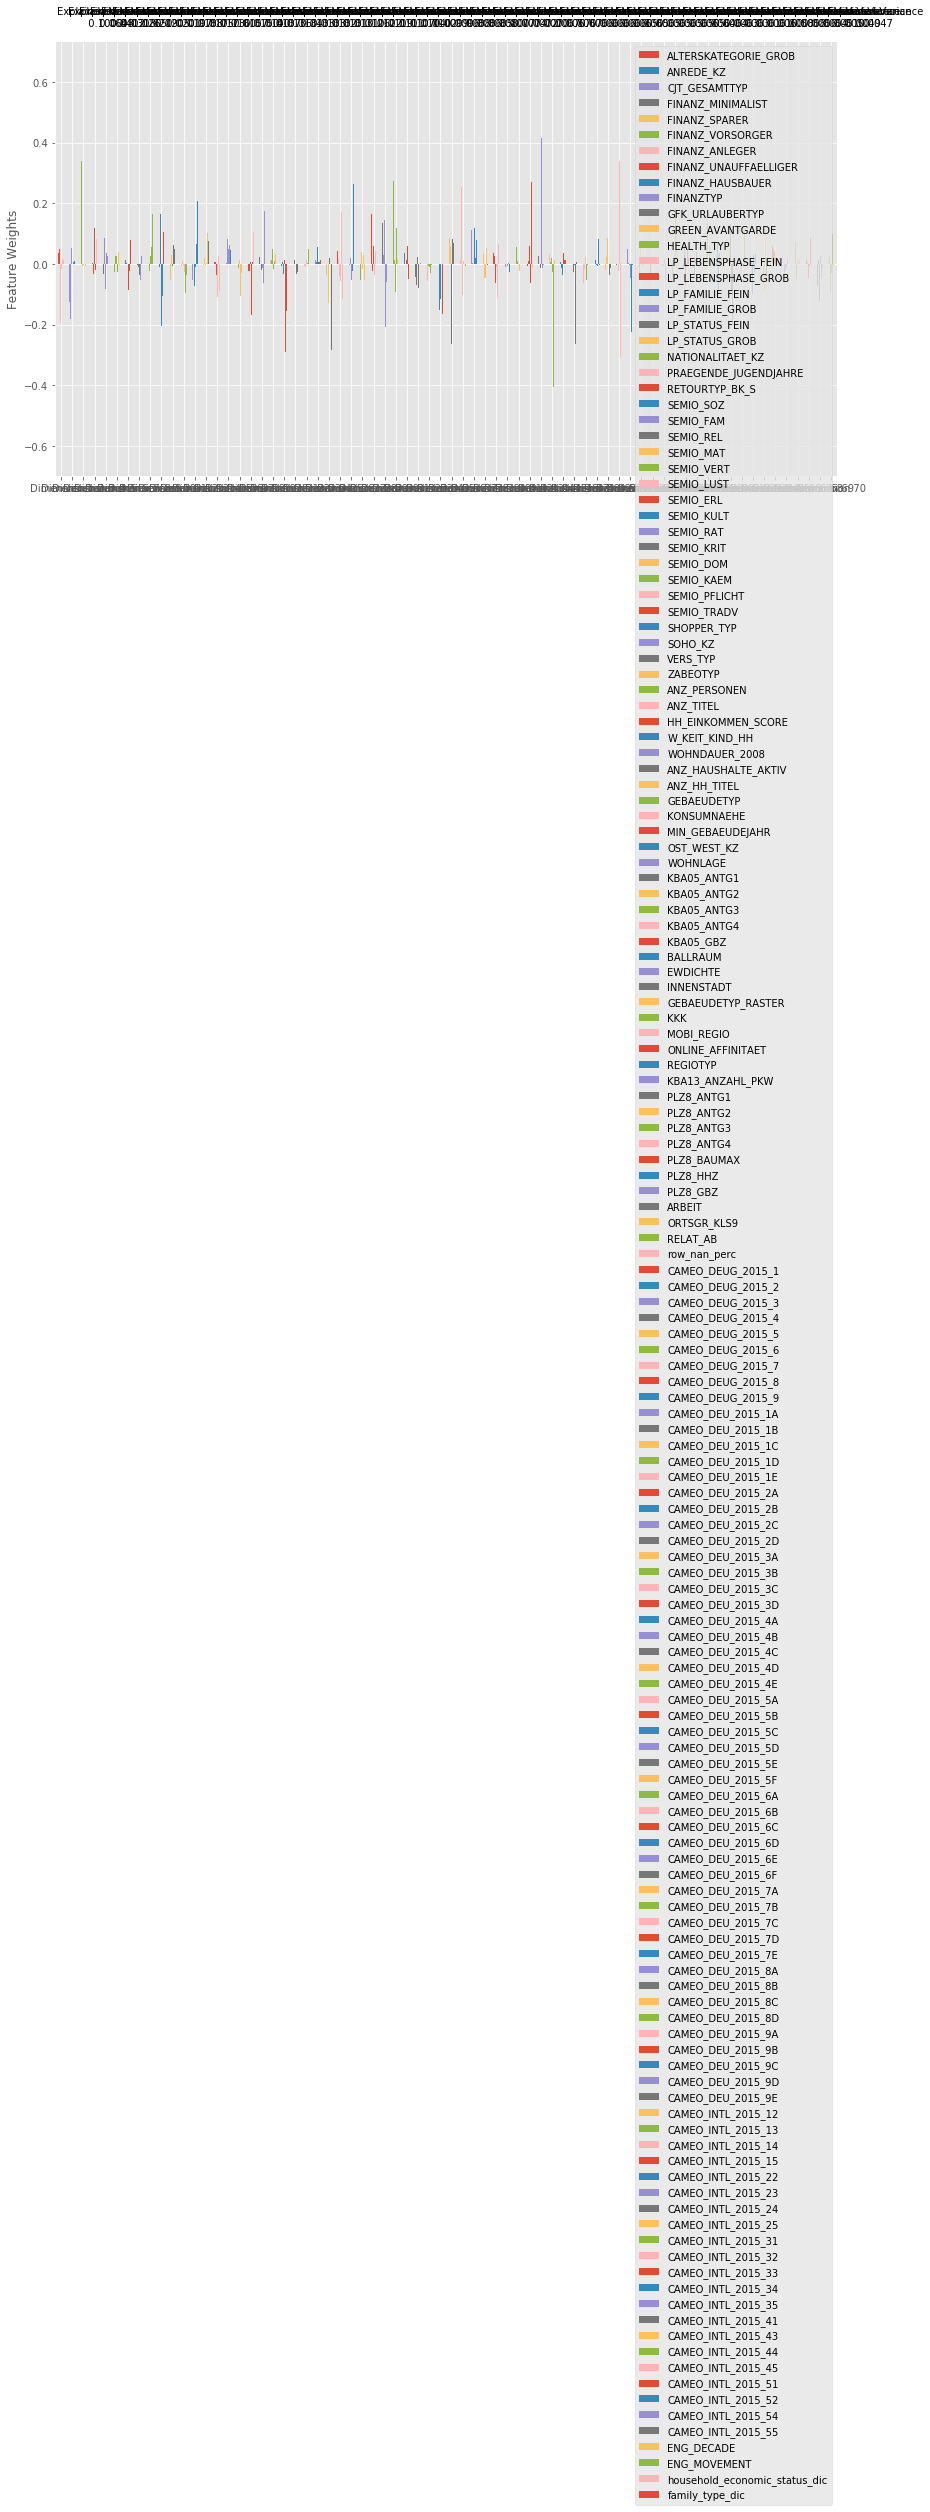

In [91]:
pca_results(missing_data_rows_low, pca)


**The graph has a bit too many colors and hard to read on such a small scale.  Despite that we see one value in the positive direction with a large weight (yellow line) while one value in the negative direction with a large weight. (blue line)**

In [92]:
comp_pos1, comp_neg1 = map_pca_weights_to_feats(pca, missing_data_rows_low, 1)
create_bar_table(comp_pos1, comp_neg1)

,
household_economic_status_dic,0.1927
PLZ8_ANTG3,0.1878
HH_EINKOMMEN_SCORE,0.1843
PLZ8_ANTG4,0.1808
PLZ8_BAUMAX,0.1774
ORTSGR_KLS9,0.1576
EWDICHTE,0.1557
FINANZ_HAUSBAUER,0.1484
CAMEO_INTL_2015_51,0.1312
KBA05_ANTG4,0.1297


**Notes:  Here we see that for every positive variable move, the negative variable move mores a bit more meaning they are not equal.  However this pattern changes when variable KBA05_ANTG4 is introduced.  Then the pattern becomes the reverse, meaning the positive variable move is a bit more than the negative variable move.**

This makes sense as it was told, "To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other."

In [93]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_pos1, comp_neg1 = map_pca_weights_to_feats(pca, missing_data_rows_low, 2)
create_bar_table(comp_pos1, comp_neg1)


,
ALTERSKATEGORIE_GROB,0.255
FINANZ_VORSORGER,0.2352
SEMIO_ERL,0.2044
SEMIO_LUST,0.1786
RETOURTYP_BK_S,0.162
W_KEIT_KIND_HH,0.1188
FINANZTYP,0.1174
FINANZ_MINIMALIST,0.1053
SHOPPER_TYP,0.0911
SEMIO_KRIT,0.0862


**Notes:  Here for the second component PCA analysis, a correlation pattern for every move in the every negative variable direction is a bit higher than its counter in every positive variable direction.  The difference between the two becomes more apparent in the bottom listed variables, as the difference is higher than the top difference.**

In [94]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_pos1, comp_neg1 = map_pca_weights_to_feats(pca, missing_data_rows_low, 3)
create_bar_table(comp_pos1, comp_neg1)


,
SEMIO_VERT,0.3384
SEMIO_FAM,0.2654
SEMIO_SOZ,0.2649
SEMIO_KULT,0.2545
FINANZ_MINIMALIST,0.147
SEMIO_REL,0.1069
FINANZTYP,0.1042
RETOURTYP_BK_S,0.089
SEMIO_MAT,0.0767
W_KEIT_KIND_HH,0.0707


**Notes: Interestingly, the top variable of SEMIO_VERT has a positive direction that is nearly equal to the negative direction weight.  The pattern trend for this n_component is that the positive direction weight is lower than the negative by much more in other prior n_components.  The trend is apparent in variable FINANZ_MINIMALIST but almost normalizes by PLZ8_BAUMAX to an near equal balance between both directions.**

### Discussion 2.3: Interpret Principal Components


In the first weighted pca component we find the positive values:

- household_economic_status_dic: has a value 0.1927, this means the customer is more likely to have a properous household type
- PLZ8_ANTG3: has a value of 0.1878, this means the customer is has a "average share of 1-2 family homes"

In the first weighted pca component we find the negative values:
- LP_STATUS_FEIN: has a weighted value of -0.2024, the customer for this component is least likley to be orientation-seeking low-income earners
- LP_STATUS_GROB: has a weighted value of-0.2, the customer for this component is least likely to be average earners.  They are either above or below.

In the second weighted pca component we find the positive values:
- ALTERSKATEGORIE_GROB: has a weighted value of 0.255, this means that the customer has has an age between 30-45 years of age and can slightly be above that range
- FINANZ_VORSORGER: has a weighted value of 0.2352: this means the customer has a high financial status

In the second weighted pca component we find the negative values:
- PRAEGENDE_JUGENDJAHRE: has a weighted value of -0.2551, this means the customer is less likely to be in their 40s, have avantgarde political views or live in both east and west germany. 
- ENG_DECADE: has a value of weighted -0.253, this means the customer is less likely to be in their 60s.

In the third weighted pca component we find the positive values:
- SEMIO_VERT: has a weighted value of 0.3384, this means the customer has a high affinity personality
- SEMIO_FAM: has a weighted value of 0.2654, this means that the customer also has a very high affinity personality

In the third weighted pca component we find the negative values:
- ANREDE_KZ: has a weighted value of -0.3644, is is below far from -1: unknown, 1:Male, and 2: Female.  So I am not sure what it means perhaps a unknown gender.
- SEMIO_KAEM: has a weighted value of -0.3356, this means that the customer does not have above a high affinity to average affinity personality

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [95]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
#in case if kmeans
from sklearn.cluster import MiniBatchKMeans

# run MiniBatchKMeans k-means clustering on the data and...
scores = {}
for k in range(2, 31):
    scores[k] = np.abs(MiniBatchKMeans(n_clusters=k, random_state=0).fit(missing_data_rows_low).score(missing_data_rows_low))


    
    

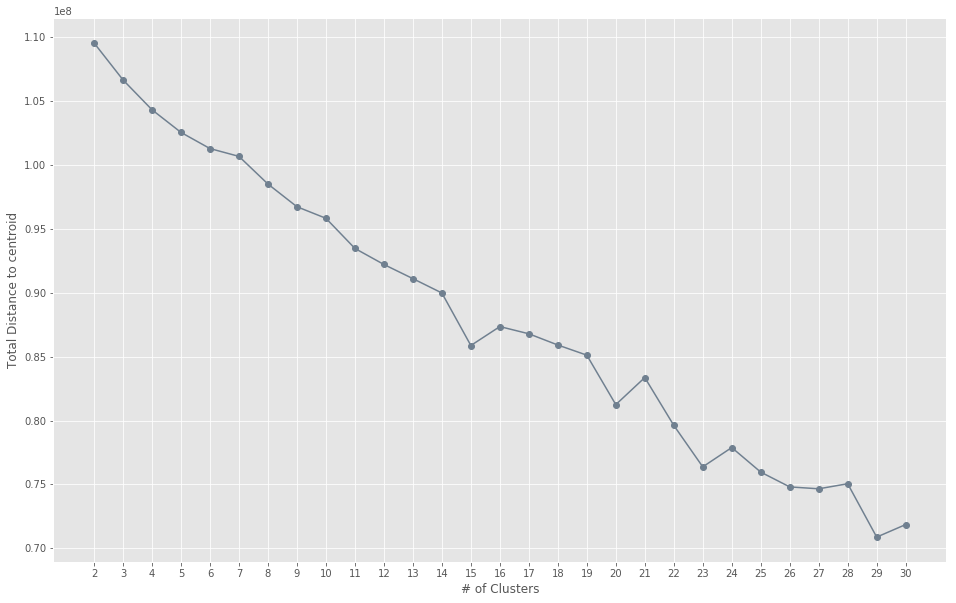

In [95]:
#computes the the distance from a cluster count range, then plots the relationship on a graph
# Plot relationship plot
fig, ax = plt.subplots(figsize=(16,10))    
ax = pd.Series(scores).plot(marker='o', color='slategray')
ax.set_xticks(np.arange(2, 31), minor=False);  
ax.set_xlabel("# of Clusters")
ax.set_ylabel("Total Distance to centroid");

In [96]:
#based on plot I could use 9-12 clusters


In [97]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = MiniBatchKMeans(n_clusters=9)
model_general = kmeans.fit(missing_data_rows_low)
predict_general = model_general.predict(missing_data_rows_low)


### Discussion 3.1: Apply Clustering to General Population

I used MiniBatchKMeans since Kmeans was taking too long on this dataset.  This may have caused some sharp spikes in the graph.

There is not a perfect clear elbow joint plot where one can see the joint hinge between a high slope and a low slope. However, a method of finding linear tangent lines to the curvature of the slope/ or points can deduct to finding separation.  From this method I concluded the elbow joint to be in the range of having 9 to 12 optimal clusters.  Going with the lower end of 9 clusters will make the later anaylsis easier in understanding, as I have to account for less variables.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [98]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [99]:
print(customers)

        AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0              2                     4          1            5.0   
1             -1                     4          1            NaN   
2             -1                     4          2            2.0   
3              1                     4          1            2.0   
4             -1                     3          1            6.0   
5              1                     3          1            4.0   
6              2                     4          1            2.0   
7              1                     4          1            2.0   
8              2                     4          2            1.0   
9              1                     3          1            3.0   
10            -1                     3          2            5.0   
11             1                     4          1            3.0   
12            -1                     4          1            5.0   
13            -1                     3          

In [100]:
spike_cols = [col for col in customers.columns if 'X' in col]

print(list(customers))


['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05

Clean the Data

In [101]:
df_cust = clean_data(customers)

Identified missing or unknown data values and converted them to NaNs.
Removed selected columns and rows
Selected, re-encoded, and engineered column values


In [102]:
print(list(df_cust))

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8

In [103]:
a = df_cust['CAMEO_INTL_2015_wealth'] == 'X'
a.sum()

101

In [104]:
print(df_cust.dtypes)

ALTERSKATEGORIE_GROB           int64
ANREDE_KZ                      int64
FINANZ_MINIMALIST              int64
FINANZ_SPARER                  int64
FINANZ_VORSORGER               int64
FINANZ_ANLEGER                 int64
FINANZ_UNAUFFAELLIGER          int64
FINANZ_HAUSBAUER               int64
GREEN_AVANTGARDE               int64
HEALTH_TYP                     int64
LP_LEBENSPHASE_FEIN          float64
LP_LEBENSPHASE_GROB          float64
PRAEGENDE_JUGENDJAHRE          int64
RETOURTYP_BK_S               float64
SEMIO_SOZ                      int64
SEMIO_FAM                      int64
SEMIO_REL                      int64
SEMIO_MAT                      int64
SEMIO_VERT                     int64
SEMIO_LUST                     int64
SEMIO_ERL                      int64
SEMIO_KULT                     int64
SEMIO_RAT                      int64
SEMIO_KRIT                     int64
SEMIO_DOM                      int64
SEMIO_KAEM                     int64
SEMIO_PFLICHT                  int64
S

In [105]:
df_cust['CAMEO_INTL_2015_wealth'] = pd.to_numeric(df_cust['CAMEO_INTL_2015_wealth'],errors='coerce')

In [106]:
df_cust['CAMEO_INTL_2015_lifestage'] = pd.to_numeric(df_cust['CAMEO_INTL_2015_lifestage'],errors='coerce')

In [107]:
df_cust['CAMEO_INTL_2015'] = pd.to_numeric(df_cust['CAMEO_INTL_2015'],errors='coerce')

In [108]:
df_cust.drop(columns=['CAMEO_INTL_2015'])

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ENG_DECADE,ENG_MOVEMENT,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,4,1,5,1,5,1,2,2,1,1,...,1.0,5.0,5.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0
1,4,2,5,1,5,1,4,4,1,2,...,3.0,3.0,2.0,3.0,5.0,3.0,2.0,2.0,3.0,4.0
2,4,1,5,1,5,2,1,2,0,2,...,1.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
3,3,1,3,1,4,4,5,2,0,3,...,2.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
4,3,1,5,1,5,1,2,3,1,3,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,2.0,3.0,4.0
5,4,1,5,1,5,1,1,2,1,2,...,1.0,5.0,5.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0
6,4,1,5,1,5,1,2,2,1,1,...,1.0,3.0,3.0,3.0,4.0,3.0,2.0,2.0,1.0,5.0
7,4,2,2,2,5,1,1,5,0,2,...,5.0,5.0,4.0,3.0,8.0,3.0,1.0,1.0,5.0,5.0
8,3,1,5,2,4,1,3,1,1,3,...,1.0,5.0,5.0,3.0,6.0,4.0,4.0,2.0,1.0,5.0
9,4,1,5,1,5,1,3,2,1,1,...,1.0,3.0,3.0,2.0,5.0,1.0,2.0,2.0,1.0,4.0


In [109]:
print(df_cust.dtypes)

ALTERSKATEGORIE_GROB           int64
ANREDE_KZ                      int64
FINANZ_MINIMALIST              int64
FINANZ_SPARER                  int64
FINANZ_VORSORGER               int64
FINANZ_ANLEGER                 int64
FINANZ_UNAUFFAELLIGER          int64
FINANZ_HAUSBAUER               int64
GREEN_AVANTGARDE               int64
HEALTH_TYP                     int64
LP_LEBENSPHASE_FEIN          float64
LP_LEBENSPHASE_GROB          float64
PRAEGENDE_JUGENDJAHRE          int64
RETOURTYP_BK_S               float64
SEMIO_SOZ                      int64
SEMIO_FAM                      int64
SEMIO_REL                      int64
SEMIO_MAT                      int64
SEMIO_VERT                     int64
SEMIO_LUST                     int64
SEMIO_ERL                      int64
SEMIO_KULT                     int64
SEMIO_RAT                      int64
SEMIO_KRIT                     int64
SEMIO_DOM                      int64
SEMIO_KAEM                     int64
SEMIO_PFLICHT                  int64
S

In [110]:
df_cust.shape

(136615, 70)

In [111]:
df_cust.isnull().any().count()

70

Data Transformation

In [112]:

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import Normalizer
imputer = Imputer(missing_values='NaN', strategy='mean')


# Imput missing values in the full df with the mean

X_cust_imp = imputer.fit_transform(df_cust)


Do PCA and reduction

In [113]:
from numpy import array
pca_reshape = X_cust_imp.reshape(1, -1)
# reshape
print(data)
pca_2 = do_pca(70, pca_reshape)


0         NaN
1         1.0
2         4.0
3         2.0
4         3.0
5         4.0
6         2.0
7         4.0
8         3.0
9         5.0
10        1.0
11        NaN
12        3.0
13        3.0
14        NaN
15        1.0
16        1.0
17        NaN
18        4.0
19        4.0
20        4.0
21        5.0
22        1.0
23        3.0
24        NaN
25        3.0
26        NaN
27        1.0
28        3.0
29        2.0
         ... 
891191    4.0
891192    2.0
891193    3.0
891194    4.0
891195    5.0
891196    3.0
891197    4.0
891198    4.0
891199    1.0
891200    2.0
891201    1.0
891202    1.0
891203    5.0
891204    4.0
891205    4.0
891206    5.0
891207    1.0
891208    4.0
891209    1.0
891210    1.0
891211    1.0
891212    1.0
891213    4.0
891214    3.0
891215    1.0
891216    1.0
891217    1.0
891218    4.0
891219    1.0
891220    3.0
Name: family_type_dic, Length: 891221, dtype: float64


/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/pca.py:423: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Clustering and KMeans

In [114]:
kmeans = KMeans(n_clusters=9)
model_general = kmeans.fit(X_cust_imp)
predict_general_pop = model_general.predict(X_cust_imp)

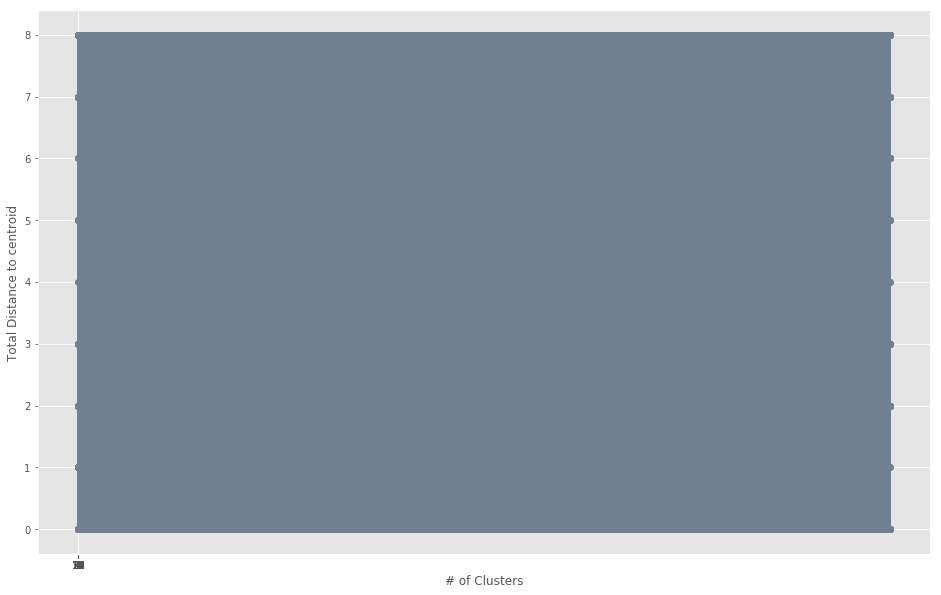

In [115]:
fig, ax = plt.subplots(figsize=(16,10))    
ax = pd.Series(predict_general_pop).plot(marker='o', color='slategray')
ax.set_xticks(np.arange(2, 31), minor=False);  
ax.set_xlabel("# of Clusters")
ax.set_ylabel("Total Distance to centroid");

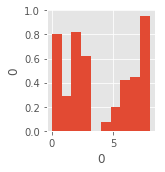

In [168]:
g = sns.pairplot(pd.DataFrame(predict_general_pop));
#need help clarifying, data not showing

In [125]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Obtain missing row data for customer dataset
missing_row_data_2 = customers.isnull().sum(axis=1)
customer_rows_deleted = customers[customers.index.isin(missing_row_data_2[missing_row_data_2 > 9].index)]
customer_rows_deleted[:4]


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,4.0,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,4.0,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
10,NaN,3.0,2,5.0,4,2,4,4,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,4.0,1,6.0,5,3,4,2,3,1,...,4.0,1.0,0.0,0.0,1.0,3.0,4.0,4.0,6.0,5.0


In [126]:
customer_rows_deleted.shape

(61179, 85)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [117]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Count number of predictions for each customer segment

customer_clusters = pd.Series(predict_general)
cc = customer_clusters.value_counts().sort_index()
cc = pd.Series(cc)
cc


0     68847
1    112902
2     60840
3     48921
4     19783
5    129588
6    119076
7    118400
8     87155
dtype: int64

In [118]:
population_clusters = pd.Series(predict_general_pop)
pc = population_clusters.value_counts().sort_index()
pc = pd.Series(pc)
pc

0    23744
1     8613
2    24208
3    18258
4     2159
5     5777
6    12390
7    13304
8    28162
dtype: int64

In [119]:
# Create a dataframe from population and customer segments
final_df = pd.concat([pc, cc], axis=1).reset_index()
final_df.columns = ['cluster','population','customer']
final_df

,cluster,population,customer
0,0,23744,68847
1,1,8613,112902
2,2,24208,60840
3,3,18258,48921
4,4,2159,19783
5,5,5777,129588
6,6,12390,119076
7,7,13304,118400
8,8,28162,87155


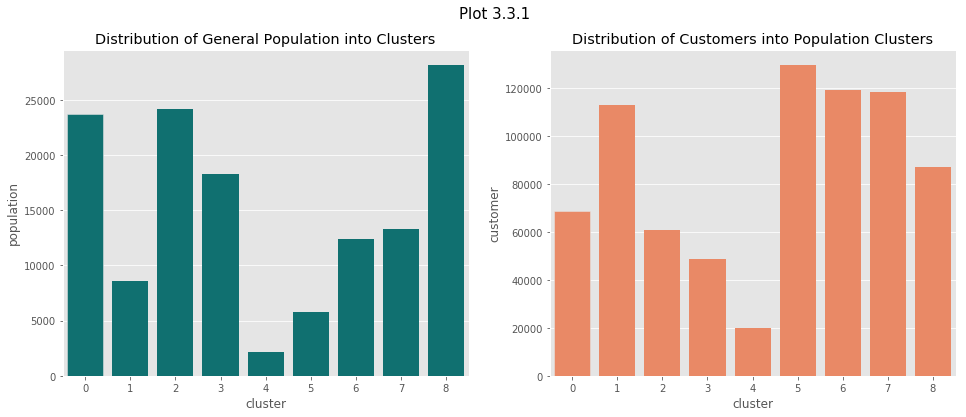

In [120]:
# Visualize dataframe as bar charts
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x='cluster',y='population',color='teal',edgecolor='.9',data=final_df)
plt.title("Distribution of General Population into Clusters")

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x='cluster',y='customer',color='coral',edgecolor='.9',data=final_df)
plt.title("Distribution of Customers into Population Clusters")
plt.suptitle("Plot 3.3.1", fontsize=15);

In [121]:
# Add ratio and ratio difference for each cluster to the dataframe
final_df['pop_%'] = (final_df['population']/final_df['population'].sum()*100).round(2)
final_df['cust_%'] = (final_df['customer']/final_df['customer'].sum()*100).round(2)
final_df['diff'] = final_df['cust_%'] - final_df['pop_%']
final_df



,cluster,population,customer,pop_%,cust_%,diff
0,0,23744,68847,17.38,8.99,-8.39
1,1,8613,112902,6.30,14.75,8.45
2,2,24208,60840,17.72,7.95,-9.77
3,3,18258,48921,13.36,6.39,-6.97
4,4,2159,19783,1.58,2.58,1.00
5,5,5777,129588,4.23,16.93,12.70
6,6,12390,119076,9.07,15.56,6.49
7,7,13304,118400,9.74,15.47,5.73
8,8,28162,87155,20.61,11.39,-9.22


In [123]:
# Missing rows from population dataset
population_rows_deleted = azdias_2.shape[0]
population_rows_deleted

891221

In [127]:
# Missing rows from customer dataset
customer_rows_deleted = customer_rows_deleted.shape[0]
customer_rows_deleted

61179

In [128]:
# Add missing data rows as an extra cluster to dataframe
final_df.loc[-1] = ['-1', population_rows_deleted, customer_rows_deleted,0,0,0]  # adding a row
final_df.index = final_df.index + 1  # shifting index
final_df.sort_index(inplace=True)

In [129]:
# Recalculate ratios and differences
final_df['pop_%'] = (final_df['population']/final_df['population'].sum()*100).round(2)
final_df['cust_%'] = (final_df['customer']/final_df['customer'].sum()*100).round(2)
final_df['diff'] = final_df['cust_%'] - final_df['pop_%']
final_df

,cluster,population,customer,pop_%,cust_%,diff
0,-1,891221,61179,86.71,7.40,-79.31
1,0,23744,68847,2.31,8.33,6.02
2,1,8613,112902,0.84,13.66,12.82
3,2,24208,60840,2.36,7.36,5.00
4,3,18258,48921,1.78,5.92,4.14
5,4,2159,19783,0.21,2.39,2.18
6,5,5777,129588,0.56,15.68,15.12
7,6,12390,119076,1.21,14.40,13.19
8,7,13304,118400,1.29,14.32,13.03
9,8,28162,87155,2.74,10.54,7.80


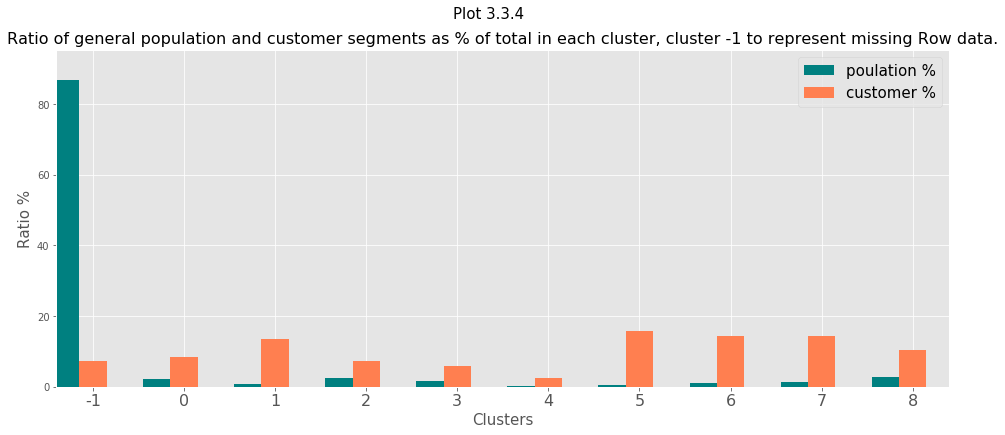

In [130]:
# Re-visualize cluster rations with missing row cluster -1

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111) # Create matplotlib axes
#ax2 = ax.twinx()

ax = final_df['pop_%'].plot(x=final_df['cluster'], kind='bar',color='teal',width=-0.3, align='edge',position=0)
ax = final_df['cust_%'].plot(kind='bar',color='coral',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=[-1,0,1,2,3,4,5,6,7,8,9,10,11])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Ratio of general population and customer segments as % of total in each cluster, cluster -1 to represent missing Row data.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.1)
plt.suptitle("Plot 3.3.4", fontsize=15)
plt.show()

In [133]:
# Proportions for general data
dict_data = {'proportion': pd.Series(population_clusters).value_counts(normalize=True, sort=False), 
          'source': 'general'}

general_proportions = pd.DataFrame(dict_data)

# Proportions for customer data
dict_data = {'proportion': pd.Series(customer_clusters).value_counts(normalize=True, sort=False), 
          'source': 'customer'}

customer_proportions = pd.DataFrame(dict_data)

# Concatenate proportions
total_proportions = pd.concat([general_proportions, customer_proportions])

In [134]:
# Check difference in cluster proportion for general vs customer populations (taking the top 2)
diff_customer_proportions = customer_proportions['proportion'] - general_proportions['proportion']
diff_customer_proportions.sort_values(ascending=False, inplace=True)
print('over-represented')
print(diff_customer_proportions[:2])
print('\nunder-represented')
print(diff_customer_proportions[-2:])

over-represented
5    0.126996
1    0.084440
Name: proportion, dtype: float64

under-represented
8   -0.092289
2   -0.097722
Name: proportion, dtype: float64


In [172]:
#for clarity for further analysis
header_list = list(azdias_3.columns.values)
header_list

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'GEBAEUDETYP',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',


In [182]:
# function showing ratios for further analysis with explained_variance_ratio_
def pca_weights(principal_component,no_of_weights):
    
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(4)
    ratio.index = dimensions
    
    weights = pd.DataFrame(pca.components_, columns=header_list)
    weights = weights.round(4)
    weights.index = dimensions
    
    result = pd.concat([ratio, weights], axis = 1, sort=False, join_axes=[ratio.index])
    result[:5]
    print("Principal Component", (principal_component))
    print('-' * 30)
    print(result.iloc[(principal_component)-1].sort_values(ascending=False)[:no_of_weights])
    print('-' * 30)
    print(result.iloc[(principal_component)-1].sort_values()[:no_of_weights])

# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

In [140]:
# Analysis of principal components of cluster 5 with over-representation in customer segment.
c_over = kmeans.cluster_centers_[5]
c_over = pd.Series(c_over)
c_over.index = c_over.index +1
c_over.sort_values(ascending=False)

39    1993.096936
56    1470.988402
42      26.915795
11      23.993249
35       8.614160
12       7.161329
13       5.764930
36       5.704345
20       5.490739
50       5.396573
19       5.208413
62       4.797473
48       4.783798
63       4.765449
21       4.746235
41       4.579713
5        4.560325
3        4.382032
15       4.273325
34       4.164965
65       4.010732
22       3.942531
53       3.907218
16       3.895101
51       3.886792
25       3.861347
24       3.836420
14       3.778605
47       3.769431
55       3.614333
         ...     
33       2.974900
23       2.969188
67       2.960759
58       2.656396
57       2.625584
8        2.551151
43       2.425480
31       2.358837
69       2.348618
64       2.287519
52       2.178639
66       2.061797
7        1.917950
10       1.905833
6        1.673360
68       1.473389
4        1.432058
30       1.430154
2        1.320235
59       1.268825
44       1.148693
61       1.103687
40       0.954821
9        0.468063
60       0

In [173]:
# Transform cluster 5 to original feature values.
cc_over = scaler.inverse_transform(pca.inverse_transform(c_over))
cc_over = pd.Series(cc_over).round(2)
cc_over.index = header_list
print(cc_over)

ALTERSKATEGORIE_GROB              275.38
ANREDE_KZ                         -58.96
CJT_GESAMTTYP                     796.56
FINANZ_MINIMALIST                 194.70
FINANZ_SPARER                      44.24
FINANZ_VORSORGER                 -280.54
FINANZ_ANLEGER                   -145.50
FINANZ_UNAUFFAELLIGER             -45.39
FINANZ_HAUSBAUER                 -605.93
FINANZTYP                        1031.44
GFK_URLAUBERTYP                  -686.25
GREEN_AVANTGARDE                 -197.37
HEALTH_TYP                        -76.19
LP_LEBENSPHASE_FEIN              -605.17
LP_LEBENSPHASE_GROB              -208.49
LP_FAMILIE_FEIN                  -319.06
LP_FAMILIE_GROB                  -117.22
LP_STATUS_FEIN                   -146.57
LP_STATUS_GROB                    -38.03
NATIONALITAET_KZ                  -85.99
PRAEGENDE_JUGENDJAHRE             415.58
RETOURTYP_BK_S                     63.00
SEMIO_SOZ                         -26.03
SEMIO_FAM                          42.45
SEMIO_REL       

In [178]:
cc_over.sort_values(ascending=False)

ANZ_HAUSHALTE_AKTIV      2501.45
MIN_GEBAEUDEJAHR         1910.70
FINANZTYP                1031.44
CJT_GESAMTTYP             796.56
SEMIO_MAT                 588.16
ONLINE_AFFINITAET         505.18
ZABEOTYP                  477.45
SHOPPER_TYP               450.40
PRAEGENDE_JUGENDJAHRE     415.58
GEBAEUDETYP               385.18
KBA05_ANTG2               374.51
ORTSGR_KLS9               373.96
SEMIO_VERT                334.07
HH_EINKOMMEN_SCORE        300.62
EWDICHTE                  291.92
SEMIO_ERL                 287.18
ENG_DECADE                279.80
SEMIO_LUST                279.70
ALTERSKATEGORIE_GROB      275.38
FINANZ_MINIMALIST         194.70
KBA05_GBZ                 136.00
PLZ8_ANTG1                132.73
SEMIO_KULT                107.49
PLZ8_GBZ                   91.63
SEMIO_DOM                  89.23
MOBI_REGIO                 88.00
SOHO_KZ                    87.13
SEMIO_KRIT                 85.17
family_type_dic            81.36
ANZ_HH_TITEL               72.37
          

In [185]:
pca_weights(5,3)

Principal Component 5
------------------------------
LP_FAMILIE_GROB        0.2888
LP_FAMILIE_FEIN        0.2871
LP_LEBENSPHASE_GROB    0.2735
Name: PC 5, dtype: float64
------------------------------
W_KEIT_KIND_HH     -0.1823
ENG_MOVEMENT       -0.1800
GREEN_AVANTGARDE   -0.1800
Name: PC 5, dtype: float64


In [ ]:
#I can also use inverse_transform.  

# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [175]:
# Analysis of principal components of cluster 2 with under-representation in customer segment.
c_under = kmeans.cluster_centers_[2]
c_under = pd.Series(c_under)
c_under.index = c_under.index +1
c_under.sort_values(ascending=False)

39    1992.742110
56     378.031105
42      31.115695
11      22.492234
35       8.678371
12       6.717118
13       5.584889
20       5.557047
65       5.552875
36       5.487897
19       5.113847
21       4.949521
5        4.553701
50       4.506568
34       4.402842
15       4.335468
49       4.238144
3        4.157964
48       4.145820
25       4.089557
24       3.990623
14       3.971125
55       3.966086
22       3.861286
16       3.857072
51       3.805601
26       3.708402
47       3.523918
41       3.497852
1        3.493473
         ...     
54       2.905775
8        2.900735
63       2.887764
28       2.880411
23       2.867523
67       2.858803
69       2.780851
58       2.778833
57       2.443035
52       2.383344
31       2.220175
43       2.071216
10       1.913169
61       1.828156
7        1.808576
6        1.579395
68       1.488487
30       1.473191
59       1.455263
4        1.433782
2        1.352611
44       1.195555
40       0.886897
60       0.598149
9        0

In [176]:
# Transform cluster 2 to original feature values.
customer_under_features = scaler.inverse_transform(pca.inverse_transform(c_under))
customer_under_features = pd.Series(customer_under_features).round(2)
customer_under_features.index = header_list
customer_under_features

ALTERSKATEGORIE_GROB             268.50
ANREDE_KZ                        -62.61
CJT_GESAMTTYP                    821.41
FINANZ_MINIMALIST                194.11
FINANZ_SPARER                     11.34
FINANZ_VORSORGER                -219.63
FINANZ_ANLEGER                  -199.51
FINANZ_UNAUFFAELLIGER            -56.66
FINANZ_HAUSBAUER                -590.16
FINANZTYP                        967.21
GFK_URLAUBERTYP                 -261.16
GREEN_AVANTGARDE                -170.96
HEALTH_TYP                       -40.99
LP_LEBENSPHASE_FEIN             -475.79
LP_LEBENSPHASE_GROB             -188.45
LP_FAMILIE_FEIN                 -314.16
LP_FAMILIE_GROB                 -112.67
LP_STATUS_FEIN                  -205.47
LP_STATUS_GROB                   -50.21
NATIONALITAET_KZ                 -41.43
PRAEGENDE_JUGENDJAHRE            323.54
RETOURTYP_BK_S                    55.55
SEMIO_SOZ                        -31.47
SEMIO_FAM                         39.96
SEMIO_REL                       -329.66


In [179]:
customer_under_features.sort_values(ascending=False)

ANZ_HAUSHALTE_AKTIV       2353.52
MIN_GEBAEUDEJAHR          1882.76
FINANZTYP                  967.21
CJT_GESAMTTYP              821.41
SEMIO_MAT                  595.29
ONLINE_AFFINITAET          580.94
ZABEOTYP                   491.41
SHOPPER_TYP                491.20
GEBAEUDETYP                428.58
KBA05_ANTG2                391.14
SEMIO_VERT                 336.66
ORTSGR_KLS9                324.81
PRAEGENDE_JUGENDJAHRE      323.54
HH_EINKOMMEN_SCORE         312.67
ALTERSKATEGORIE_GROB       268.50
EWDICHTE                   268.44
SEMIO_ERL                  267.56
ENG_DECADE                 242.86
SEMIO_LUST                 232.63
FINANZ_MINIMALIST          194.11
PLZ8_ANTG1                 152.56
KBA05_GBZ                  120.76
SEMIO_DOM                  115.23
SEMIO_KULT                 111.57
SEMIO_KRIT                  89.02
PLZ8_GBZ                    84.34
OST_WEST_KZ                 79.45
family_type_dic             78.87
MOBI_REGIO                  73.23
ANZ_HH_TITEL  

In [186]:
pca_weights(2,3)

Principal Component 2
------------------------------
ALTERSKATEGORIE_GROB    0.2550
FINANZ_VORSORGER        0.2352
SEMIO_ERL               0.2044
Name: PC 2, dtype: float64
------------------------------
PRAEGENDE_JUGENDJAHRE   -0.2551
ENG_DECADE              -0.2530
FINANZ_SPARER           -0.2475
Name: PC 2, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data


There is not a clear linear or similar relationship between the two groups.  There were minor differences and big differences.

The missing values group was qualitatively different from the main bulk of the data, and hence I treated this as an additional data cluster in this analysis.  In the general population we find much more rows deleted than the customer population, being 891221 to 61179 respectfully or about a 79.34% difference.

**The top over-represented columns were found to be cluster 5 with a 0.126996% proportion followed by cluster 1 with 0.084440% proportion.**

With a reverse cluster look up cluster 5 contains a lot of variables of “ANZ_HAUSHALTE_AKTIV“ followed by variables of “MIN_GEBAEUDEJAHR” and “FINANZTYP”.

- **ANZ_HAUSHALTE_AKTIV**: Number of households in the building
- **MIN_GEBAEUDEJAHR**: First year building was mentioned in the database
- **FINANZTYP**: Most descriptive financial type for individual

The top positive weights of cluster 5 were LP_FAMILIE_GROB, LP_FAMILIE_FEIN and LP_LEBENSPHASE_GROB.

- **LP_FAMILIE_GROB**: The family type was more likely to be couple at a weight of 0.2888
- **LP_FAMILIE_FEIN**:  The family type was more likely to be a couple at a weight of 0.2871
- **LP_LEBENSPHASE_GROB**:  the life stage was most likely between single low-income and average earners of higher age to 
single high-income earners at a weight of 0.2735

The top negative weights of cluster 5 were W_KEIT_KIND_HH, ENG_MOVEMENT and GREEN_AVANTGARDE.

- **W_KEIT_KIND_HH**: Is "not most likely" to have a child in a household at a weight of value of 0.1823
- **ENG_MOVEMENT**:  The person is not more likely to be avantgarde with a value weight of 0.1800
- **GREEN_AVANTGARDE**: Is not more likely a member of the green avantgarde with a value weight of 0.1800

**The top under-represented columns were found to be cluster 2 with a 0.097722% proportion followed by cluster 8 with 0.092289% proportion.**

With a reverse cluster look up cluster 2 contains a lot of variables of “ANZ_HAUSHALTE_AKTIV”, followed by MIN_GEBAEUDEJAHR and "FINANZTYP”.

- **ANZ_HAUSHALTE_AKTIV**: Number of households in the building
- **MIN_GEBAEUDEJAHR**: First year building was mentioned in the database
- **FINANZTYP**: Most descriptive financial type for individual

The top positive weights of cluster 2 were ALTERSKATEGORIE_GROB, FINANZ_VORSORGER and SEMIO_ERL.

- **ALTERSKATEGORIE_GROB**:  Is a person with an age around 30-45.  The value weight is at 0.2550
- **FINANZ_VORSORGER**:  More likely one who is financially prepared to live.  The value weight is at 0.2352.
- **SEMIO_ERL**: Person has a personality with a very high affinity.  The value weight is at 0.2044.

The top negative weights of cluster 2 were PRAEGENDE_JUGENDJAHRE, ENG_DECADE and FINANZ_SPARER.

- **PRAEGENDE_JUGENDJAHRE**:  Person most is not likely to be in either in their 40s, Avantgarde and live in either east or west side.  The value weight is at 0.2551.  I thought I reconfigured this column in analysis.
- **ENG_DECADE**: More likely one who is not in their 50s. At a weight of 0.2530.
- **FINANZ_SPARER**: More likely one who is not financially prepared to live. At a weight of 0.2475

In sum and in general, the over populated cluster contained individuals with a couple, and individuals with low income to average income.

In sum and in general, the under populated cluster contained individuals with an age between 30-45, individuals who are financially prepared to live, and individuals who are confident.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.